In [1]:
import os
import sys

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import math
import warnings
from sklearn.decomposition import PCA


print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from classes.regdata import RegData
from funcs.reloads import Reloader
from classes.natspatpred import NatSpatPred
from classes.voxelsieve import VoxelSieve

from funcs.analyses import fovperi_per_lay, fovperi_plot, fovparafov_roiplot, plot_scatter_with_diagonal, plot_roi_histograms

['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsd_access-0.0.1.dev0-py3.11.egg', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/cifti-1.1-py3.11.egg']


In [2]:
NSP = NatSpatPred()
NSP.initialise(verbose=True)
# importlib.reload(funcs.brain_mapping)
from funcs.brain_mapping import reg_to_nifti, vol_to_surf

rd = RegData
rl = Reloader

# Ignore the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


#### Fixing the baseline ridge script linalg warning, waht is going on??

In [3]:

rois, roi_masks, viscortex_mask = NSP.cortex.visrois_dict(verbose=False)
prf_dict = NSP.cortex.prf_dict(rois, roi_masks)


In [52]:
from scipy.stats import zscore as zs
# for subject in NSP.subjects:

subject = "subj01"
print(f"Running central patch constrained voxel selection gabor baseline analysis for subject: {subject}")
############ CONSTRAINED VOXEL SELECTION Y-MATRIX ################
##### ALSO RUN THIS FOR THE PRED FEATS SEPARATELY WITHOUT THE BASELINE #########

max_size = 2
min_size = .15
# min_size = args.min_prfsize if args.min_prfsize is not None else .15 # This is for the robustness analyses
patchbound = 1
# patchbound = args.patch_radius if args.patch_radius is not None else 1
min_nsd_R2 = 0
min_prf_R2 = 0
# fixed_n_voxels = 170

voxeldict = {}
n_voxels = []
for roi in rois:
    while True:
        print_attr = True if roi == rois[len(rois)-1] else False
        voxeldict[roi] = VoxelSieve(NSP, prf_dict, roi_masks,
                                    subject=subject, 
                                    roi=roi,
                                    patchloc='central', 
                                    max_size=max_size, 
                                    min_size=min_size, 
                                    patchbound=patchbound, 
                                    min_nsd_R2=min_nsd_R2, 
                                    min_prf_R2=min_prf_R2,
                                    print_attributes=print_attr,
                                    fixed_n_voxels=None,
                                    )
        if len(voxeldict[roi].size) > 0:
            break
        else:
            patchbound += 0.1
            print(f"No voxels found for ROI {roi} with patchbound {patchbound - 0.1}. Trying with patchbound {patchbound}.")
    n_voxels.append(len(voxeldict[roi].size))
        
max_n_voxels = np.min(n_voxels)

ydict = {}
for roi in rois:
    # ydict[roi] = NSP.analyse.load_y(subject=subject, roi=roi, voxelsieve=voxeldict[roi], n_trials=end_img-start_img).T # I changed n_trials
    ydict[roi] = NSP.analyse.load_y(subject=subject, roi=roi, voxelsieve=voxeldict[roi], n_trials="all").T # I changed n_trials
    print(f'{roi} y-matrix has dimensions: {ydict[roi].shape}')


print(f'Running the analysis for {subject}')

# Xgabor_sub = NSP.stimuli.load_gabor_output(subject=subject, file_tag='all_imgs_sf4_dir4_loc_optimal', verbose=False)
Xgabor_sub = NSP.stimuli.load_gabor_output(subject=subject, file_tag='all_imgs_sf4_dir4_allfilts', verbose=False)
Xbl = zs(Xgabor_sub[: ydict["V1"].shape[0]])
# Vgg encoding featmaps
# Xbl = NSP.stimuli.alex_featmaps([0], subject, plot_corrmx=False, smallpatch=True, modeltype="VGG")[:ydict["V1"].shape[0]]


Running central patch constrained voxel selection gabor baseline analysis for subject: subj01
V1 voxels that fulfill requirements: 437 out of 7887.
V2 voxels that fulfill requirements: 805 out of 8296.
V3 voxels that fulfill requirements: 746 out of 7022.
V4 voxels that fulfill requirements: 538 out of 3976.

Class contains the following attributes:
 .angle
 .ecc
 .figdims
 .nsd_R2
 .patchbound
 .patchcoords
 .patchmask
 .prf_R2
 .sigmas
 .size
 .vox_lim
 .vox_pick
 .xcoor
 .xyz
 .ycoor


V1 y-matrix has dimensions: (30000, 437)
V2 y-matrix has dimensions: (30000, 805)
V3 y-matrix has dimensions: (30000, 746)
V4 y-matrix has dimensions: (30000, 538)
Running the analysis for subj01
X has these dimensions: (30000, 543)


In [98]:
Xgabor_sub = NSP.stimuli.load_gabor_output(subject=subject, file_tag='all_imgs_sf4_dir4_allfilts', verbose=False)
print(Xgabor_sub.shape)

Xbl = Xgabor_sub

num_pcs = 100

pca = PCA(n_components=num_pcs)
pca.fit(Xbl)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print(f"Cumulative explained variance for {num_pcs} PCs: {cumulative_explained_variance[num_pcs-1]}")

Xbl_pcs = pca.transform(Xbl)

(30000, 543)
Cumulative explained variance for 100 PCs: 0.9299477338790894


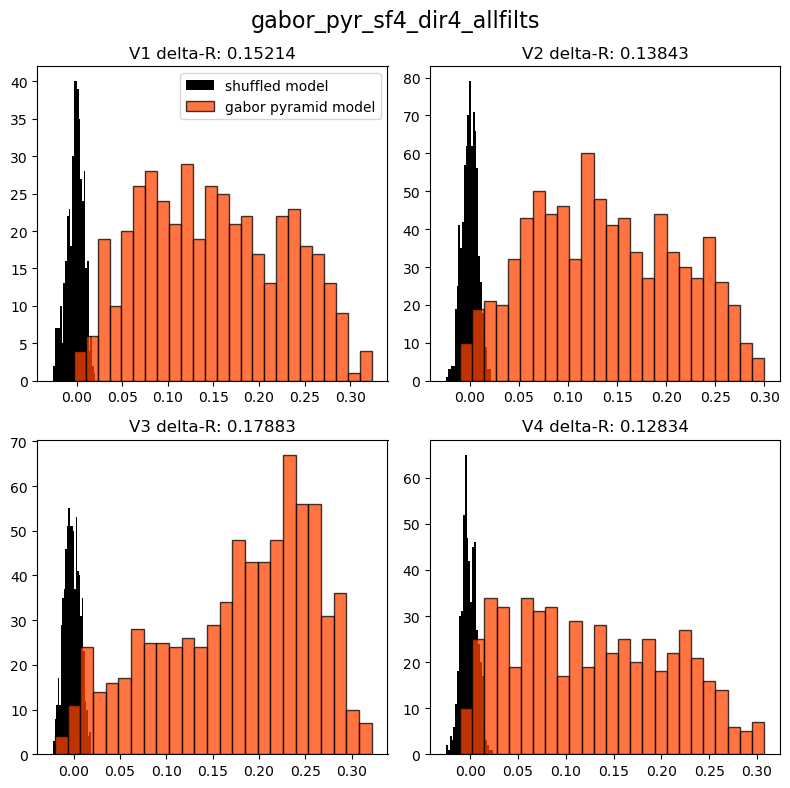

In [99]:

X_shuf = np.copy(Xbl_pcs)
np.random.shuffle(X_shuf)

reg_df = NSP.analyse.analysis_chain_slim(subject=subject,
                            ydict=ydict,
                            voxeldict=voxeldict,
                            X=Xbl_pcs,
                            alpha=.1,
                            cv=5,
                            rois=rois,
                            X_alt=X_shuf, # The baseline model
                            fit_icept=False,
                            save_outs=False,
                            regname=f"gabor_pyr_sf4_dir4_allfilts",
                            # regname="VGG16_500pc_conv0_fullviscortex",
                            plot_hist=True,
                            alt_model_type="shuffled model",
                            save_folder=f'baseline',
                            X_str=f'gabor pyramid model')

### r to r scatterplot a la glmsingle paper by prince et al

In [17]:

def plot_split_scatter(
    baseline_data,
    unpred_data,
    x_label,
    y_label,
    ax=None,
    figsize=(8, 6),
    xticks_interval=None,
    yticks_interval=None,
    baseline_colour="blue",
    unpred_colour="red",
    line_colour="black",
    legend_baseline="Baseline",
    legend_unpred="Unpred",
):
    """
    Plots a split scatter plot with baseline data on the left and unpred data on the right,
    and connects corresponding points with lines.

    Parameters:
    baseline_data (pd.Series): Data for the left side of the x-axis.
    unpred_data (pd.Series): Data for the right side of the x-axis.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis.
    ax (matplotlib.axes.Axes, optional): Axes object to plot on. If None, creates a new figure and axes.
    figsize (tuple): Size of the figure if ax is None.
    xticks_interval (int, optional): Interval for x-axis ticks.
    yticks_interval (int, optional): Interval for y-axis ticks.
    baseline_colour (str): Colour of the baseline scatter plot dots.
    unpred_colour (str): Colour of the unpred scatter plot dots.
    line_colour (str): Colour of the lines connecting the points.
    legend_baseline (str): Name for the baseline legend entry.
    legend_unpred (str): Name for the unpred legend entry.

    Returns:
    ax: The axes object of the plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Plot baseline data at a constant x-coordinate
    ax.scatter(
        [-1] * len(baseline_data), baseline_data, color=baseline_colour, alpha=0.8, s=2, label=legend_baseline
    )

    # Plot unpred data at a constant x-coordinate
    ax.scatter(
        [1] * len(unpred_data), unpred_data, color=unpred_colour, alpha=0.8, s=2, label=legend_unpred
    )

    # Draw lines connecting corresponding points
    for i in range(len(baseline_data)):
        ax.plot(
            [-1, 1], [baseline_data.iloc[i], unpred_data.iloc[i]], color=line_colour, alpha=0.1
        )

    # Add x and y labels
    ax.set_xlabel(x_label, fontsize=14, fontweight="normal")
    ax.set_ylabel(y_label, fontsize=14, fontweight="normal")

    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Set tick intervals if specified
    if xticks_interval is not None:
        ax.set_xticks(np.arange(-1, 2, xticks_interval))
    if yticks_interval is not None:
        ax.set_yticks(np.arange(min(min(baseline_data), min(unpred_data)), max(max(baseline_data), max(unpred_data)) + yticks_interval, yticks_interval))

    # Add legend
    ax.legend()

    return ax

Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101


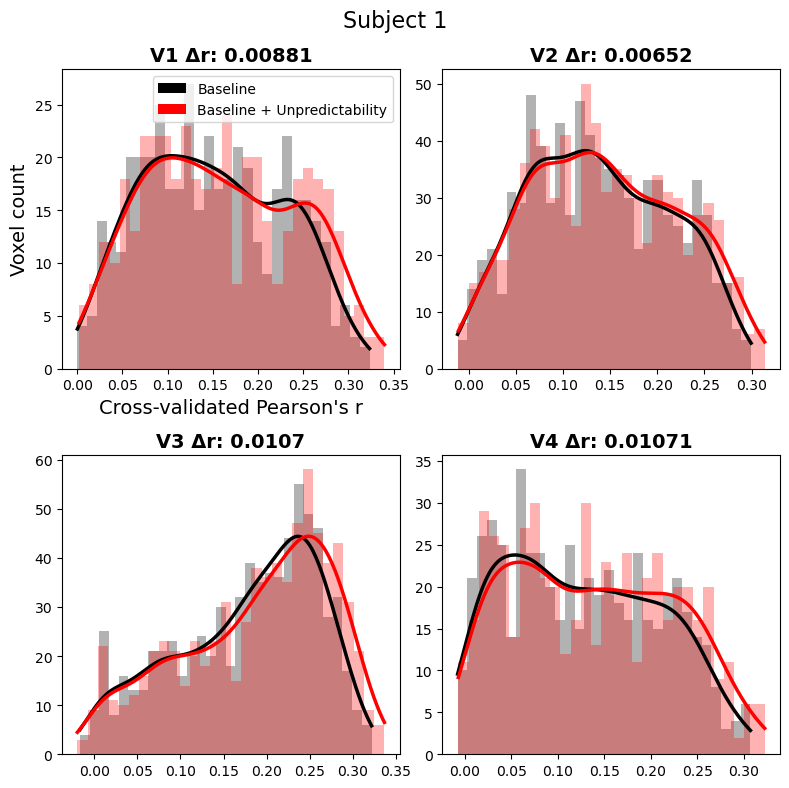

Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101


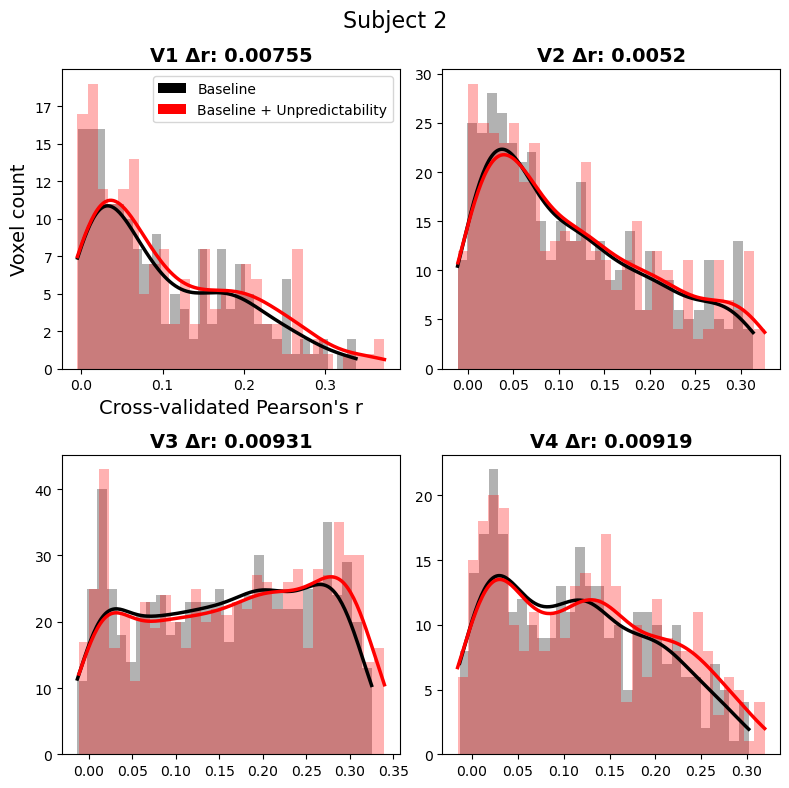

Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101


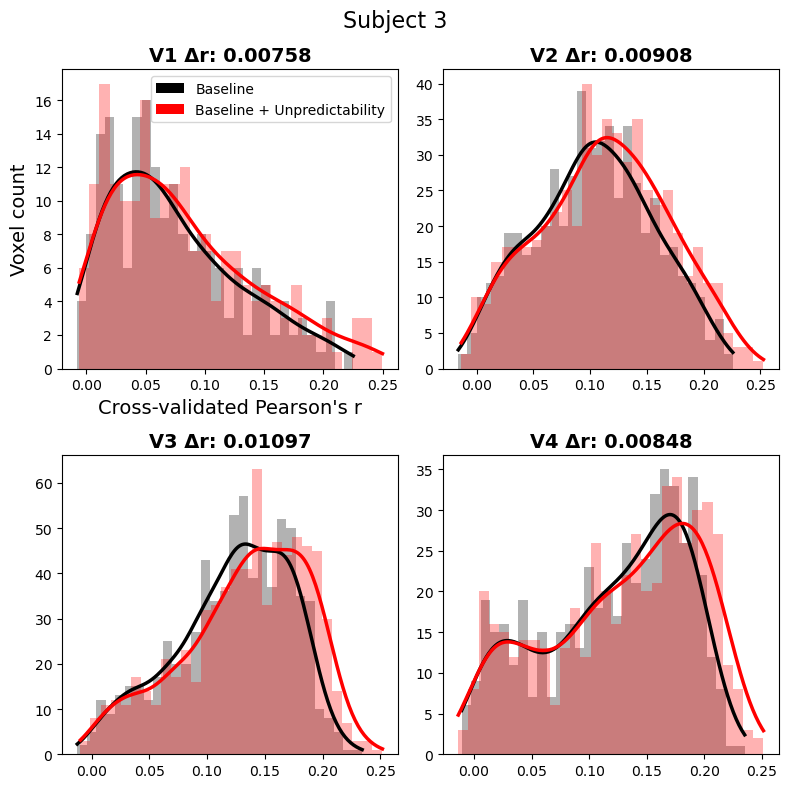

Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101


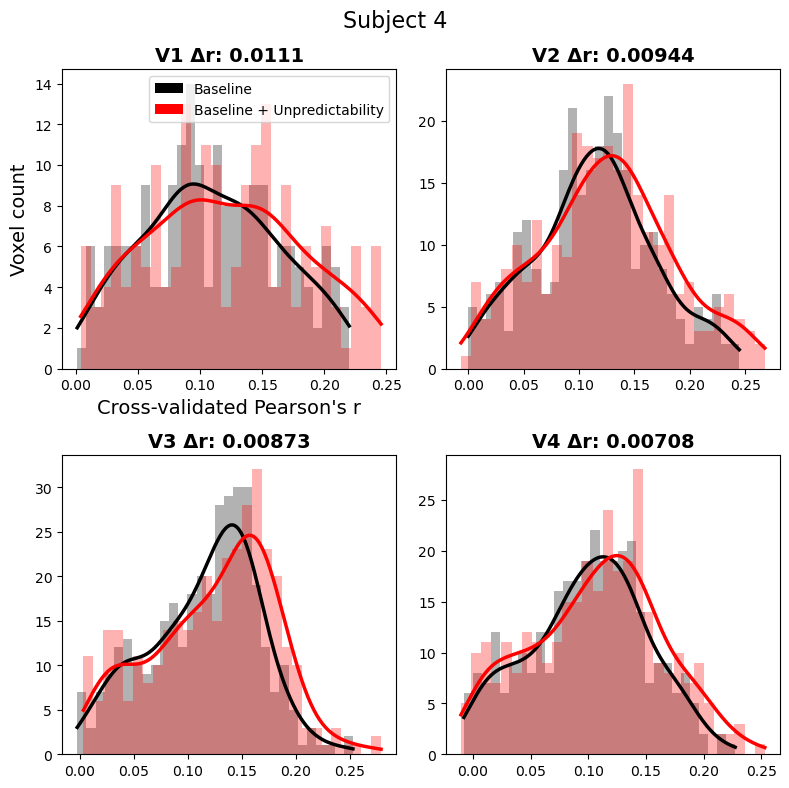

Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101


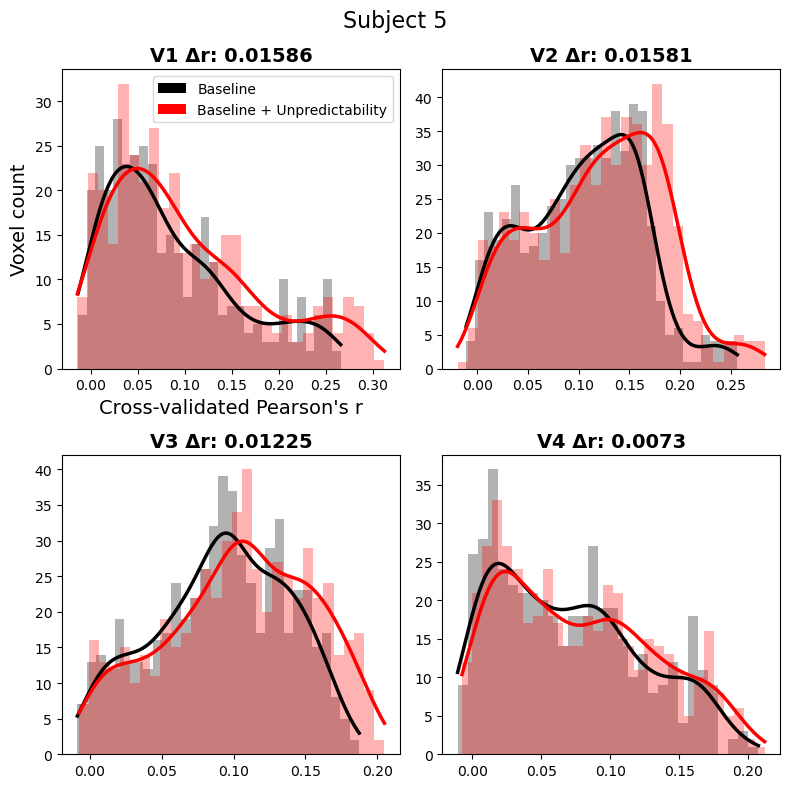

Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101


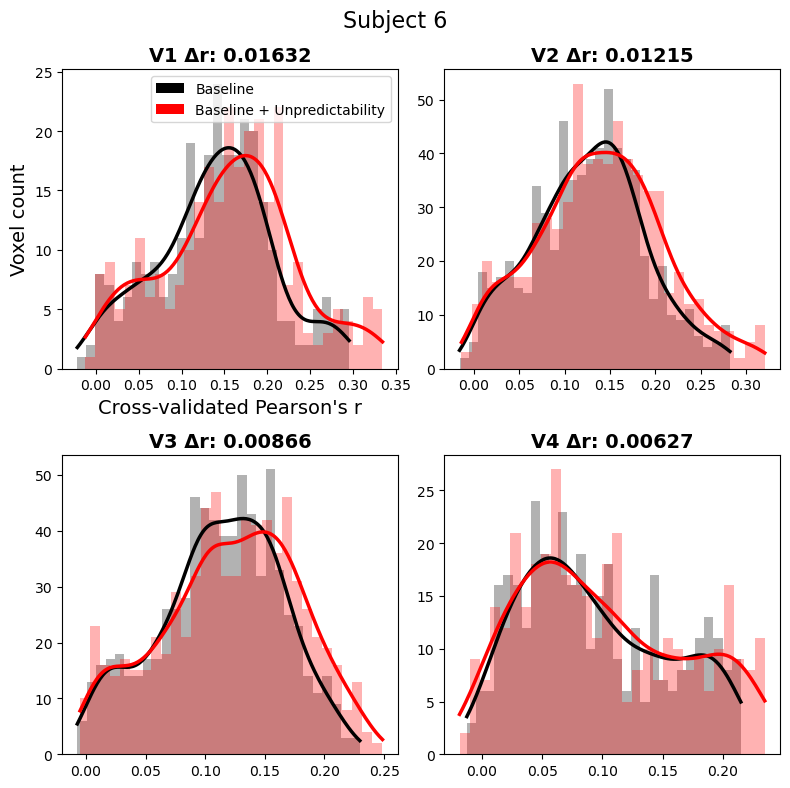

Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101


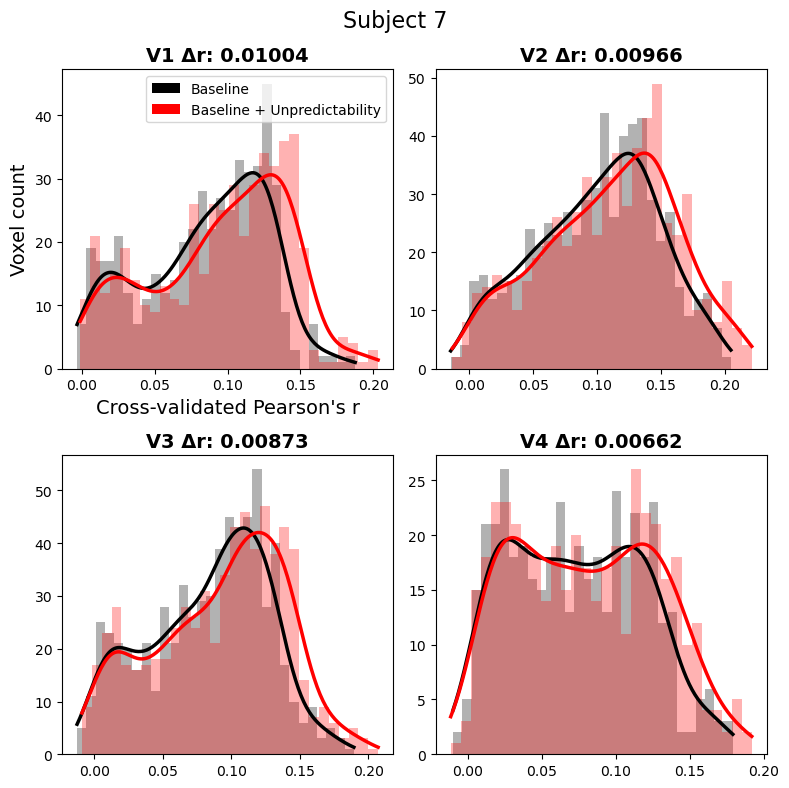

Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101


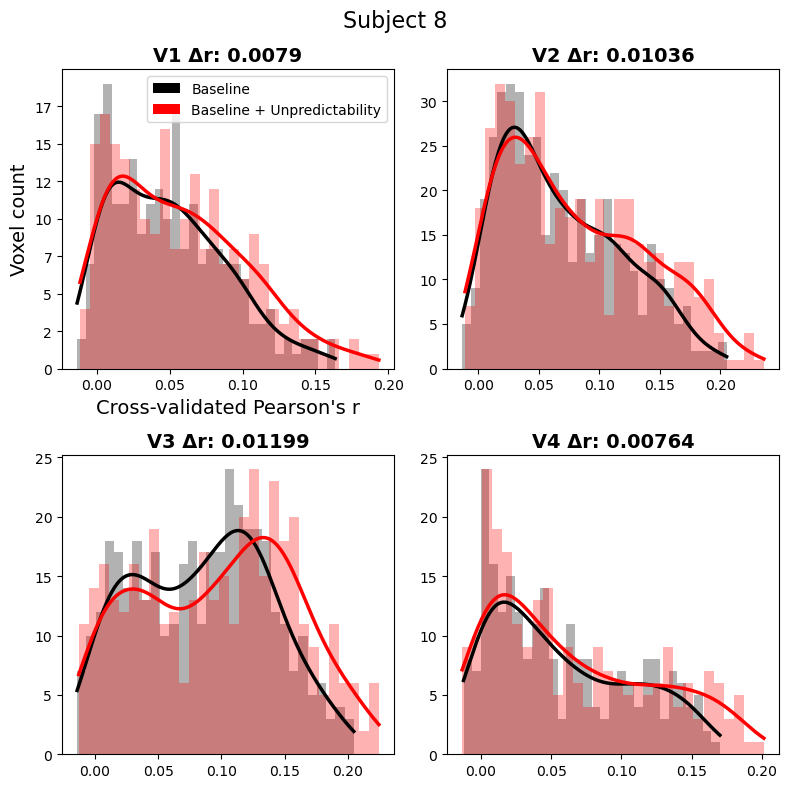

In [5]:
for sub_no, subject in enumerate(NSP.subjects):
    # fig, axs = plt.subplots(1, 1, figsize=(6, 12))  # Create subplots outside the loop

    unpred_out = rd(
        subject=subject,
        folder="unpred/vggfull_gabor_baseline_allfilts",
        # folder=f"unpred/vggfull/peri_ecc2.0_angle{angle}_gabor_allfilts",
        model="vggfull",
        statistic="R",
        verbose=False,
        skip_norm_lay=True,
    )

    baseline_out = rd(
        subject=subject,
        folder="baseline",
        model="gabor_pyr_sf4_dir4_allfilts",
        # model=f"gabor_pyr_sf4_dir4_ecc2.0_angle{angle}_allfilts",
        statistic="R",
        verbose=True,
        skip_norm_lay=True,
        single_file=True,
    )
    unpred_out.df

    mean_unpred_r = np.mean(unpred_out.df.iloc[:, 4:], axis=1)
    
    plot_roi_histograms(
    unpred_df = unpred_out,
    baseline_df=baseline_out,
    # rois= ["V1", "V2", "V3", "V4"],
    alt_model_type="Baseline",
    X_str="Baseline + Unpredictability",
    regname=f"Subject {subject[-1]}",
    colour1="black",
    colour2="red",
    n_bins=30,
    alpha=.3,
    add_smooth_curve=True,
    add_bin_edges=False,
    figsize=(8,8)
)
    
    

# plot_histograms(baseline_out.df["R_101"], mean_unpred_r, ["V1", "V2", "V3", "V4"], "Baseline", "Unpred", "Unpred delta r")

In [10]:

unpred_out.df
baseline_out.df

x   y   z roi     R_101
0      59   7  61  V1  0.145102
1      59   8  62  V1  0.097114
2      59  10  59  V1  0.027551
3      59  10  60  V1  0.005657
4      59  12  59  V1  0.194170
...   ...  ..  ..  ..       ...
1563  104  35  54  V4  0.137530
1564  105  25  55  V4  0.056950
1565  105  26  54  V4  0.022357
1566  105  27  53  V4 -0.002524
1567  105  28  53  V4 -0.013622

[1568 rows x 5 columns]

Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101
Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101


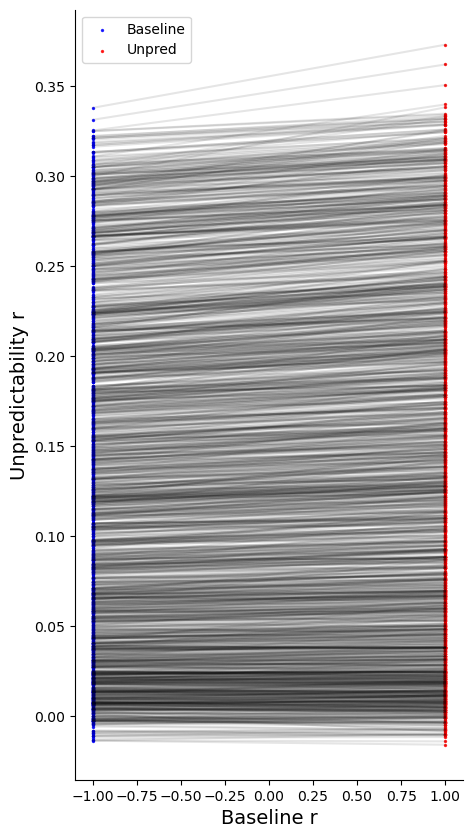

In [20]:
for sub_no, subject in enumerate(NSP.subjects[:2]):
    # fig, axs = plt.subplots(1, 1, figsize=(6, 12))  # Create subplots outside the loop

    unpred_out = rd(
        subject=subject,
        folder="unpred/vggfull_gabor_baseline_allfilts",
        # folder=f"unpred/vggfull/peri_ecc2.0_angle{angle}_gabor_allfilts",
        model="vggfull",
        statistic="R",
        verbose=False,
        skip_norm_lay=True,
    )

    baseline_out = rd(
        subject=subject,
        folder="baseline",
        model="gabor_pyr_sf4_dir4_allfilts",
        # model=f"gabor_pyr_sf4_dir4_ecc2.0_angle{angle}_allfilts",
        statistic="R",
        verbose=True,
        skip_norm_lay=True,
        single_file=True,
    )
    unpred_out.df

    mean_unpred_r = np.mean(unpred_out.df.iloc[:, 4:], axis=1)


_ = plot_split_scatter(
    baseline_out.df["R_101"],
    mean_unpred_r,
    "Baseline r",
    "Unpredictability r",
    figsize=(5,10)
    # ax=axs,
)



## ACQUIRE THESE PLOTS FOR ALL THE PARAFOVEAL ANALYSES AS WELL, MAKE THEM BEAUTIFUL LIKE THE ELIFE PAPER

Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101
Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101
Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101
Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101
Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101
Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101
Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101
Processing file gabor_pyr_sf4_dir4_allfilts_regdf.csv for layer 101


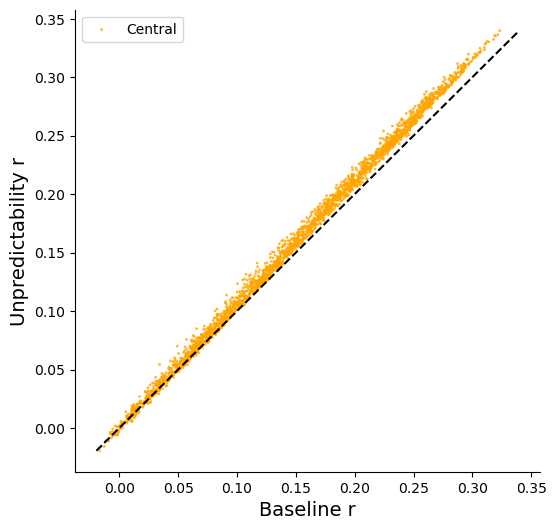

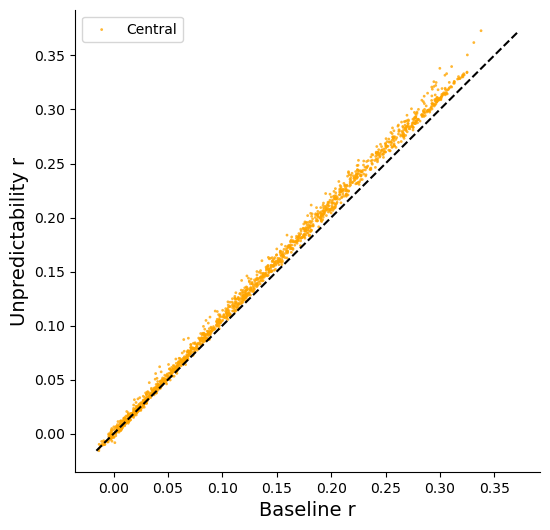

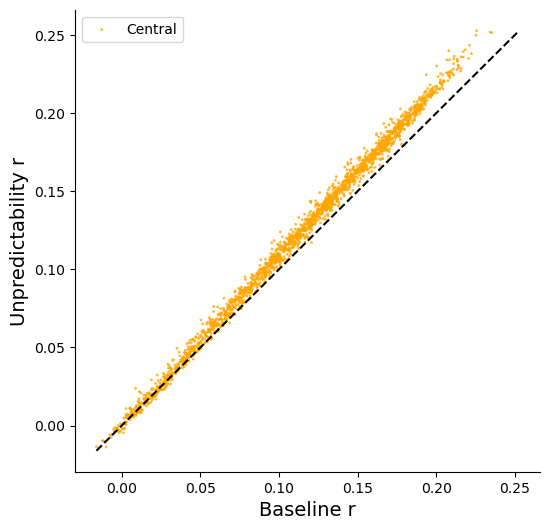

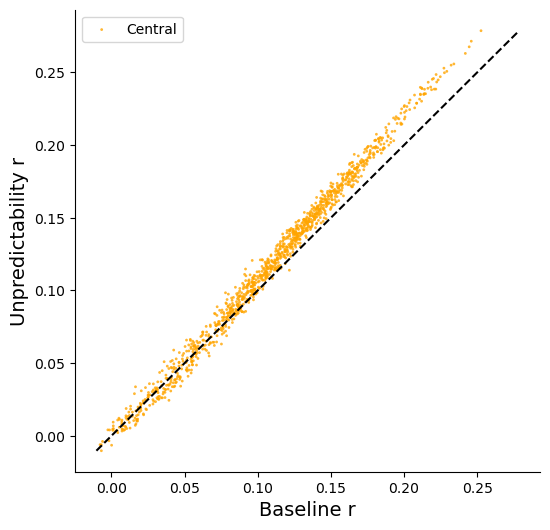

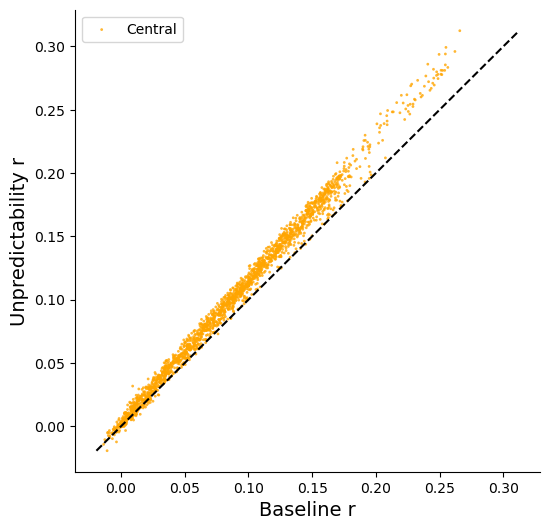

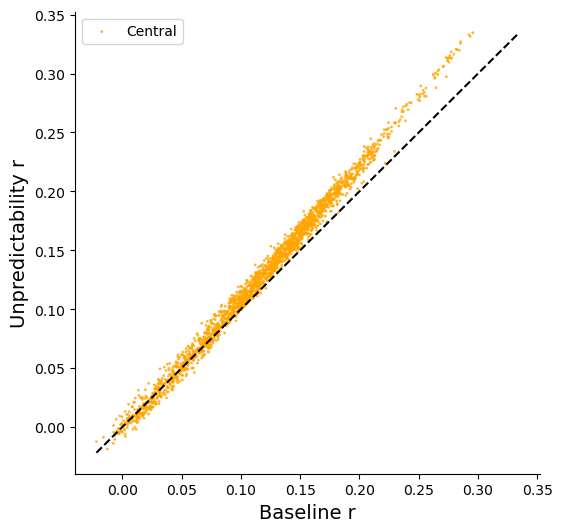

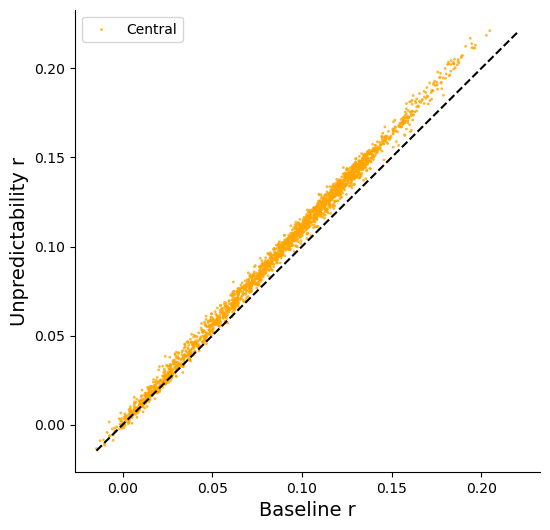

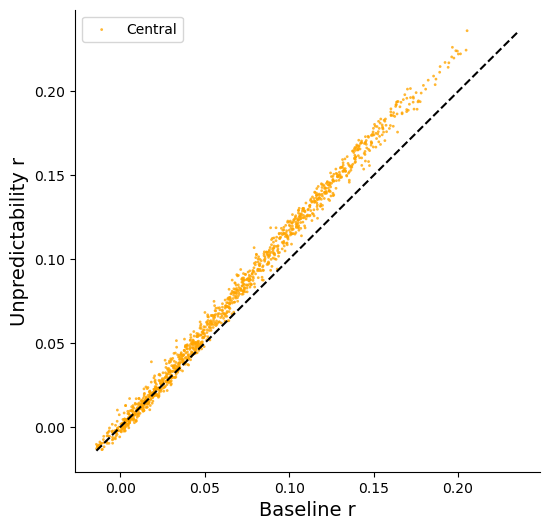

In [13]:
for sub_no, subject in enumerate(NSP.subjects):
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))  # Create subplots outside the loop

    unpred_out = rd(
        subject=subject,
        folder="unpred/vggfull_gabor_baseline_allfilts",
        # folder=f"unpred/vggfull/peri_ecc2.0_angle{angle}_gabor_allfilts",
        model="vggfull",
        statistic="R",
        verbose=False,
        skip_norm_lay=True,
    )

    baseline_out = rd(
        subject=subject,
        folder="baseline",
        model="gabor_pyr_sf4_dir4_allfilts",
        # model=f"gabor_pyr_sf4_dir4_ecc2.0_angle{angle}_allfilts",
        statistic="R",
        verbose=True,
        skip_norm_lay=True,
        single_file=True,
    )
    unpred_out.df

    mean_unpred_r = np.mean(unpred_out.df.iloc[:, 4:], axis=1)

    plot_scatter_with_diagonal(
        baseline_out.df["R_101"],
        mean_unpred_r,
        "Baseline r",
        "Unpredictability r",
        ax=axs,
        dotcolour="orange",
        legend_name="Central",
    )

### This codeblock gives you the scatter plots for unpredictability effects in parafovea and distinguishes between the angles.

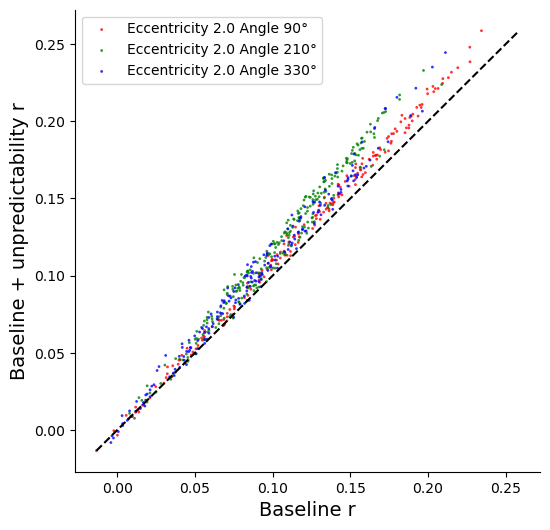

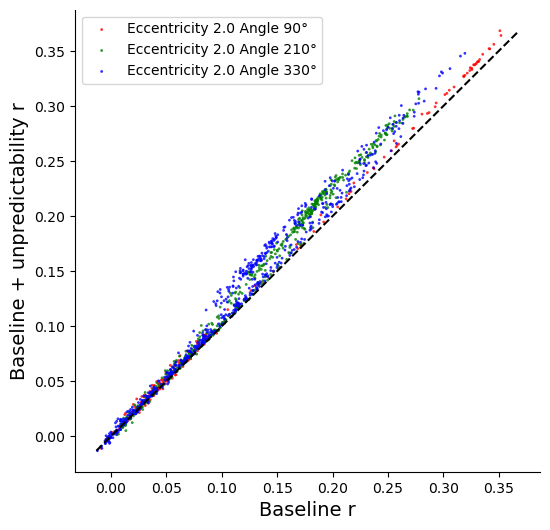

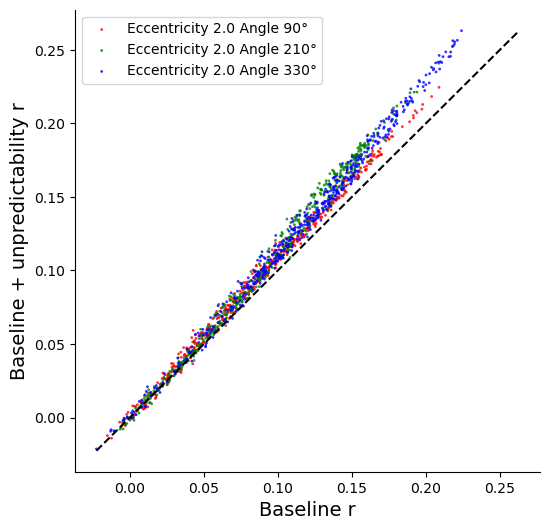

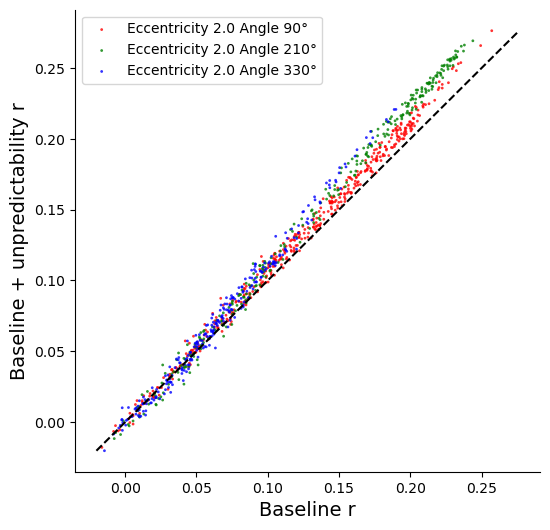

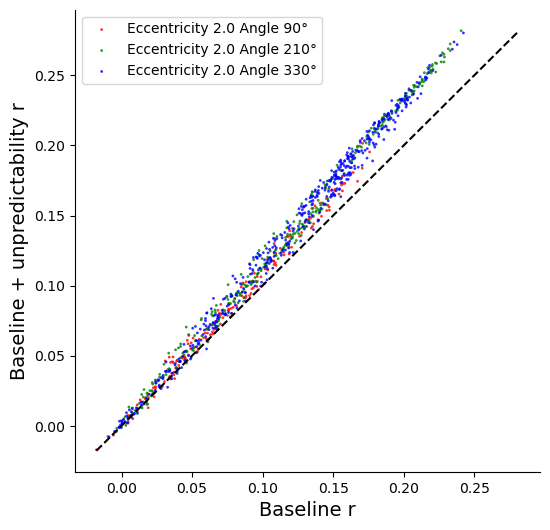

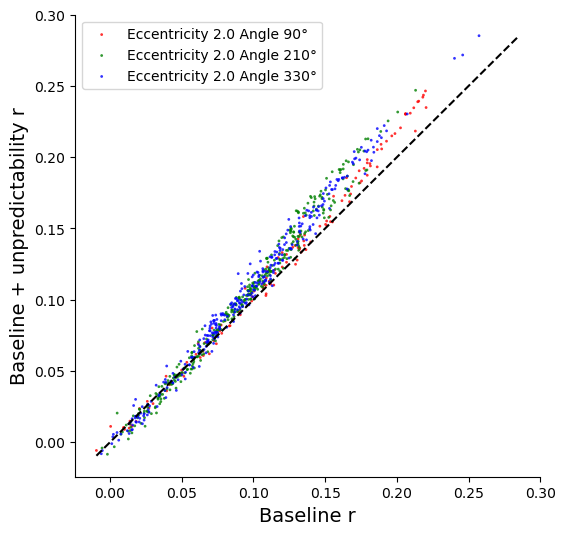

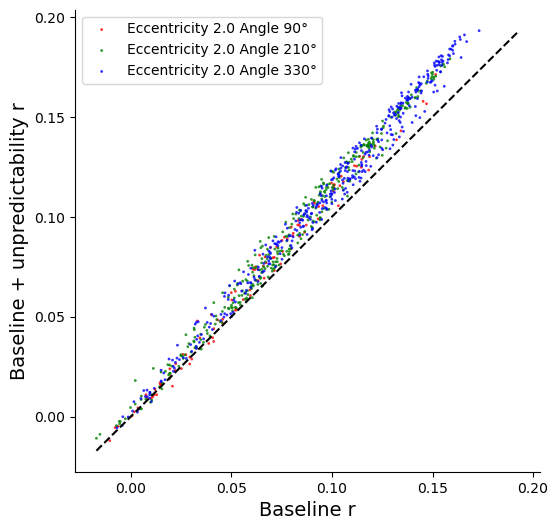

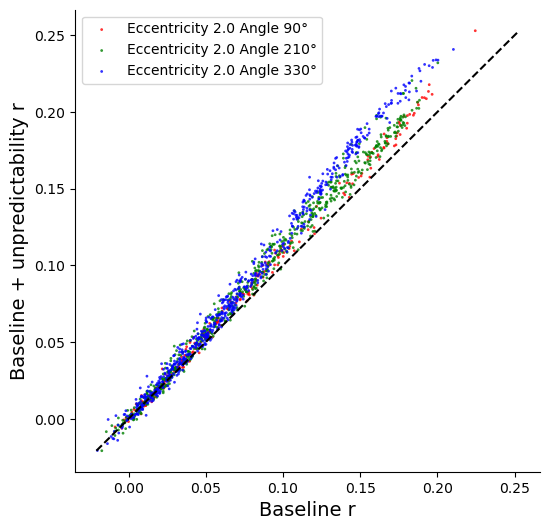

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize empty lists
baseline_stack = []
unpred_stack = []
colours = ["red", "green", "blue"]
for sub_no, subject in enumerate(NSP.subjects):
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))  # Create subplots outside the loop

    for angle_colour, angle in enumerate([90, 210, 330]):
        row = sub_no // 4  # Determine the row index
        col = sub_no % 4  # Determine the column index

        unpred_out = rd(
            subject=subject,
            folder=f"unpred/vggfull/peri_ecc2.0_angle{angle}_gabor_allfilts",
            model="vggfull",
            statistic="R",
            verbose=False,
            skip_norm_lay=True,
        )

        baseline_out = rd(
            subject=subject,
            folder="baseline",
            model=f"gabor_pyr_sf4_dir4_ecc2.0_angle{angle}_allfilts",
            statistic="R",
            verbose=False,
            skip_norm_lay=True,
            single_file=True,
        )

        mean_unpred_r = np.mean(unpred_out.df.iloc[:, 4:], axis=1)

        # Append data to the lists
        baseline_stack.append(baseline_out.df["R_101"].values)
        unpred_stack.append(mean_unpred_r.values)

        plot_scatter_with_diagonal(
            baseline_out.df["R_101"],
            mean_unpred_r.values,
            "Baseline r",
            "Baseline + unpredictability r",
            ax=axs,
            dotcolour=colours[angle_colour],
            add_diagonal=False,
            legend_name=f"Eccentricity 2.0 Angle {angle}°",
        )
    # Convert lists to numpy arrays
    baseline_stack = np.concatenate(baseline_stack)
    unpred_stack = np.concatenate(unpred_stack)

    # Plot on the subplot
    plot_scatter_with_diagonal(
        baseline_stack,
        unpred_stack,
        "Baseline r",
        "Baseline + unpredictability r",
        ax=axs,
        dotcolour=colours[angle_colour],
        add_scat=False,
        add_diagonal=True,
    )

    # Clear the lists for the next subject
    baseline_stack = []
    unpred_stack = []

# plt.tight_layout()
# plt.show()

In [5]:
test_peri = rd(
    subject="subj03",
    folder="baseline",
    model="gabor_pyr_sf4_dir4_ecc2.0_angle90",
    statistic="delta_r",
    verbose=True,
    skip_norm_lay=False,
)


test_peri.df

Processing file gabor_pyr_sf4_dir4_ecc2.0_angle90_regdf.csv for layer 101


x   y   z roi  delta_r_101
0     65  15  45  V1     0.043091
1     65  15  46  V1     0.033787
2     65  28  39  V1     0.013512
3     66  28  39  V1    -0.012864
4     66  29  39  V1     0.032550
..   ...  ..  ..  ..          ...
558  105  35  51  V4     0.118505
559  105  35  52  V4     0.124391
560  105  36  50  V4     0.043757
561  107  34  50  V4     0.026019
562  113  31  48  V4     0.021327

[563 rows x 5 columns]

In [6]:
# for subject in NSP.subjects:
# for angle in [90, 210, 330]:
subject = "subj01"
angle = 90

vgg16results = rd(
    subject=subject,
    folder=f"unpred/vggfull/peri_ecc2.0_angle{angle}_gabor",
    model="vggfull",
    statistic="delta_r",
    verbose=False,
    skip_norm_lay=True,
)  # Norm layer is not in the encoding featmaps (i think)
datfram = vgg16results.df
# vgg16results.assign_layers(max_or_weighted="max",
#                         verbose=True,
#                         title=f"Unpredictability layer assignment across visual cortex ecc 2.0 angle {angle}\nVGG16, ΔR based (Baseline vs. Baseline + Unpredictability)",
#                         #   figsize = (6 , 5.5))
#                         figsize = (6.5 , 5))

# vgg16results.mean_lines(fit_polynom = False,
#             polynom_order = 4,
#             verbose = True,
#             plot_catplot = False,
#             title = "Layer-specific unpredictability effect across visual cortex\nVGG16, Δβ based (Baseline vs. Baseline + Unpredictability)")

datfram

Empty DataFrame
Columns: []
Index: []

In [27]:
# Peripheral results, delta r unpredictability
for angle_no, angle in enumerate([90, 210, 330]):

    results = rd(
        subject=subject,
        folder=f"unpred/vggfull/peri_ecc2.0_angle{angle}_gabor",
        model="vggfull",
        statistic="delta_r",
        verbose=False,
        skip_norm_lay=True,
    )  # Norm layer is not in the encoding featmaps (i think)
    if angle_no == 0:
        peri_df = results.df
    else:
        peri_df = pd.concat([peri_df, results.df])

# datfram["roi"]

In [28]:
peri_df

x   y   z roi  delta_r_2  delta_r_3  delta_r_4  delta_r_5  delta_r_6  \
0     63  17  55  V1   0.014806   0.015336   0.014465   0.014277   0.013970   
1     67   6  66  V1   0.026967   0.027290   0.026288   0.025859   0.026171   
2     67   8  65  V1   0.043803   0.044003   0.043533   0.043171   0.043674   
3     67   9  64  V1   0.050901   0.051065   0.051214   0.050971   0.051476   
4     67   9  66  V1   0.009871   0.010096   0.009996   0.009844   0.009894   
..   ...  ..  ..  ..        ...        ...        ...        ...        ...   
193   46  24  60  V4   0.004317   0.004778   0.004820   0.004818   0.004664   
194   49  25  60  V4   0.003999   0.003339   0.003060   0.003013   0.003189   
195   49  26  60  V4   0.003381   0.002890   0.002570   0.002568   0.002674   
196   96  22  60  V4   0.012616   0.012229   0.012623   0.012570   0.012653   
197  106  21  62  V4   0.060979   0.060019   0.060525   0.059821   0.061192   

     delta_r_7  delta_r_8  delta_r_9  delta_r_10  delta_r_11  delta_r_12  \
0     0.013690   0.013273   0.012857    0.012563    0.011665    0.009896   
1     0.025025   0.022433   0.021794    0.021650    0.020940    0.019814   
2     0.042395   0.039442   0.038262    0.037467    0.036085    0.034159   
3     0.050496   0.047962   0.046595    0.045454    0.043533    0.040611   
4     0.009525   0.008777   0.008309    0.008038    0.007740    0.007734   
..         ...        ...        ...         ...         ...         ...   
193   0.004663   0.004525   0.004292    0.004192    0.003688    0.002652   
194   0.002590   0.001743   0.001658    0.001595    0.001699    0.002136   
195   0.002217   0.001577   0.001476    0.001418    0.001431    0.001598   
196   0.012210   0.011703   0.011319    0.010636    0.010070    0.009158   
197   0.061630   0.060213   0.061045    0.061853    0.062244    0.061968   

     delta_r_13  delta_r_14  delta_r_15  delta_r_16  delta_r_17  
0      0.006554    0.004568    0.007226    0.014806    0.015336  
1      0.015838    0.012814    0.020273    0.026967    0.027290  
2      0.027708    0.022737    0.030537    0.043803    0.044003  
3      0.032275    0.026210    0.033884    0.050901    0.051065  
4      0.006895    0.005842    0.006552    0.009871    0.010096  
..          ...         ...         ...         ...         ...  
193    0.000918    0.000153    0.000456    0.004317    0.004778  
194    0.002741    0.003046    0.008180    0.003999    0.003339  
195    0.001692    0.001759    0.006104    0.003381    0.002890  
196    0.007346    0.006319    0.009933    0.012616    0.012229  
197    0.056020    0.050040    0.053383    0.060979    0.060019  

[660 rows x 20 columns]

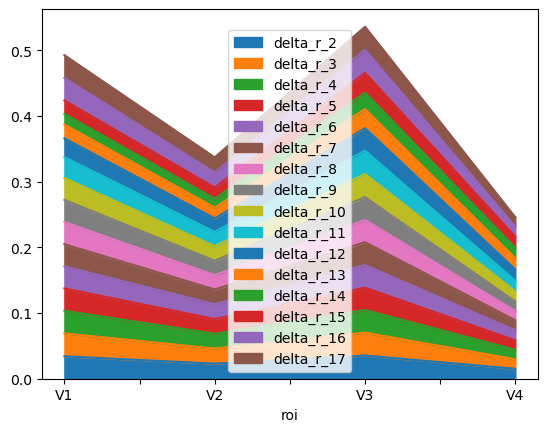

delta_r_2  delta_r_3  delta_r_4  delta_r_5  delta_r_6  delta_r_7  \
roi                                                                     
V1    0.034129   0.034849   0.034459   0.034033   0.033544   0.033780   
V2    0.022941   0.023009   0.022641   0.022268   0.022548   0.022564   
V3    0.035251   0.034906   0.034511   0.033962   0.034479   0.034786   
V4    0.015151   0.014410   0.014527   0.014304   0.015297   0.015291   

     delta_r_8  delta_r_9  delta_r_10  delta_r_11  delta_r_12  delta_r_13  \
roi                                                                         
V1    0.033891   0.033666    0.033197    0.031919    0.028562    0.020961   
V2    0.021758   0.021942    0.022141    0.021788    0.020473    0.016393   
V3    0.033920   0.034651    0.035324    0.035413    0.034264    0.029088   
V4    0.014010   0.014572    0.015415    0.016198    0.017212    0.016906   

     delta_r_14  delta_r_15  delta_r_16  delta_r_17  
roi                                                  
V1     0.016214    0.020472    0.034129    0.034849  
V2     0.013517    0.017072    0.022941    0.023009  
V3     0.025106    0.030123    0.035251    0.034906  
V4     0.015846    0.017030    0.015151    0.014410

In [238]:
# Group by 'roi' and calculate the mean, excluding the first three columns
grouped = peri_df.iloc[:, 3:].groupby("roi").mean()

# Plot the mean values
grouped.plot(kind="area")

# Show the plot
plt.show()

grouped

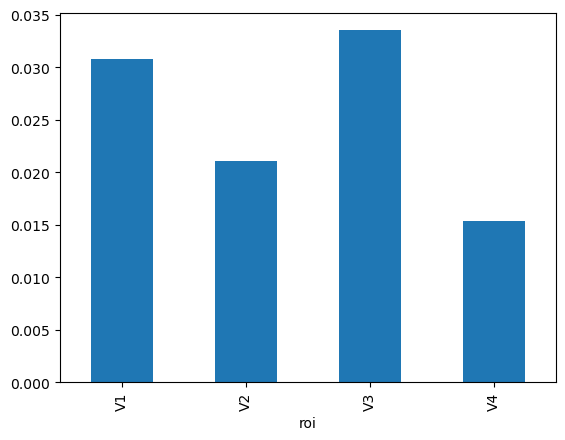

In [35]:
# Group by 'roi' and calculate the mean, excluding the first three columns
grouped = peri_df.iloc[:, 3:].groupby("roi").mean()

# Calculate the mean over all columns
peri_mean = grouped.mean(axis=1)

# Plot the mean values
peri_mean.plot(kind="bar")

# Show the plot
plt.show()

### Trying out whether I can do the same without taking the mean across abstraction layers of unpred feats

In [4]:
stat = "beta_unpred"
subject = "subj07"

# Peripheral results, delta r unpredictability
# for angle_no, angle in enumerate([90, 210, 330]):
for angle_no, angle in enumerate([210]):

    results = rd(
        subject=subject,
        folder=f"unpred/vggfull/peri_ecc2.0_angle{angle}_gabor",
        model="vggfull",
        statistic=stat,
        verbose=False,
        skip_norm_lay=True,
    )  # Norm layer is not in the encoding featmaps (i think)
    if angle_no == 0:
        peri_df = results.df
    else:
        peri_df = pd.concat([peri_df, results.df])

# Group by 'roi' and calculate the mean, excluding the first three columns
peri_grouped = peri_df.iloc[:, 3:].groupby("roi").mean()

fov_results = rd(
    subject=subject,
    folder=f"unpred/vggfull_gabor_baseline",
    model="vggfull",
    statistic=stat,
    verbose=False,
    skip_norm_lay=True,
)  # Norm layer is not in the encoding featmaps (i think)

fov_df = fov_results.df

# Group by 'roi' and calculate the mean, excluding the first three columns
fov_grouped = fov_df.iloc[:, 3:].groupby("roi").mean()

In [5]:
# Assuming the two dataframes are `fov_df` and `peri_df`

# Add a new column 'source' to each dataframe
fov_grouped["source"] = "fov"
peri_grouped["source"] = "peri"

# Concatenate the two dataframes
combined_df = pd.concat([fov_grouped, peri_grouped])

# Reset the index
combined_df.reset_index(inplace=True)

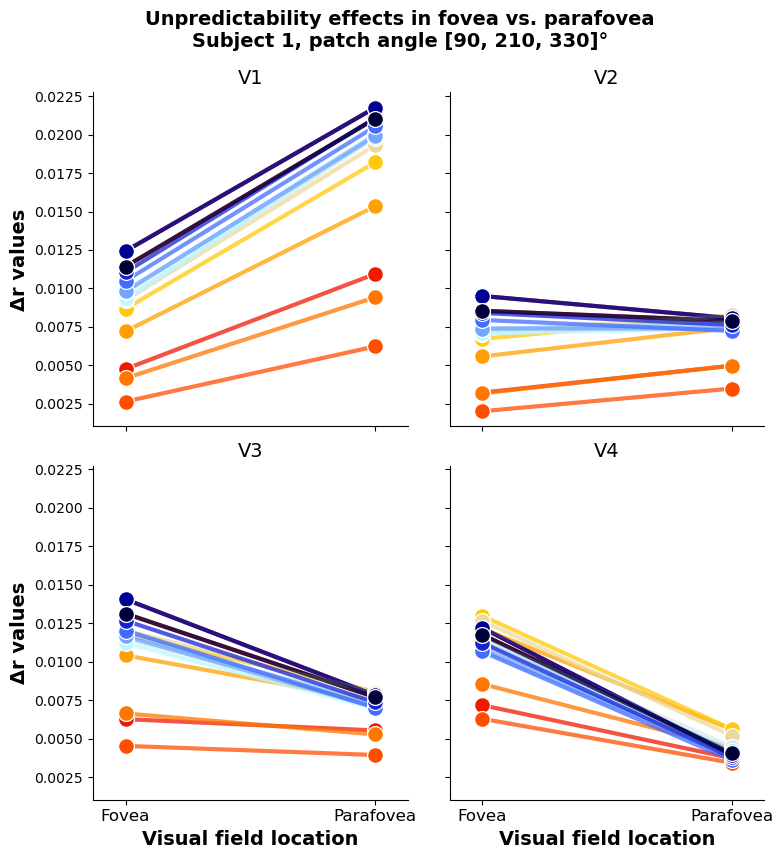

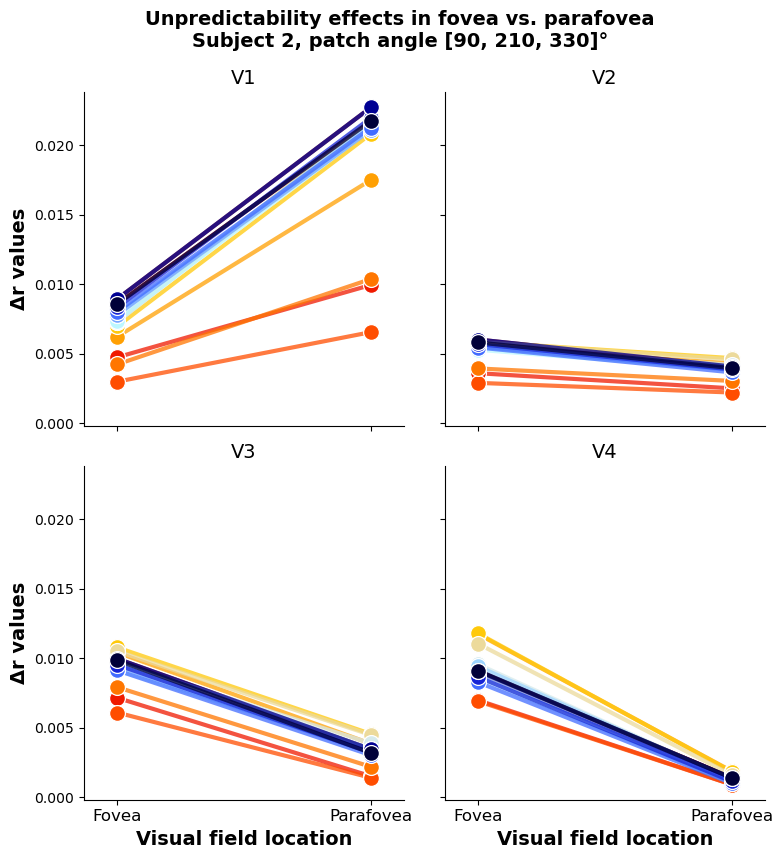

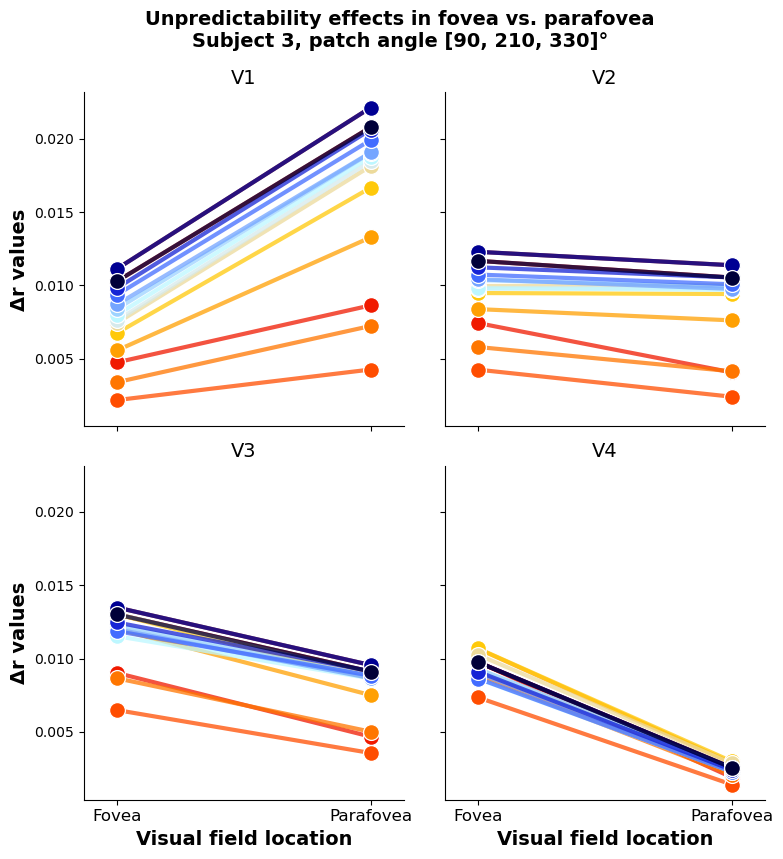

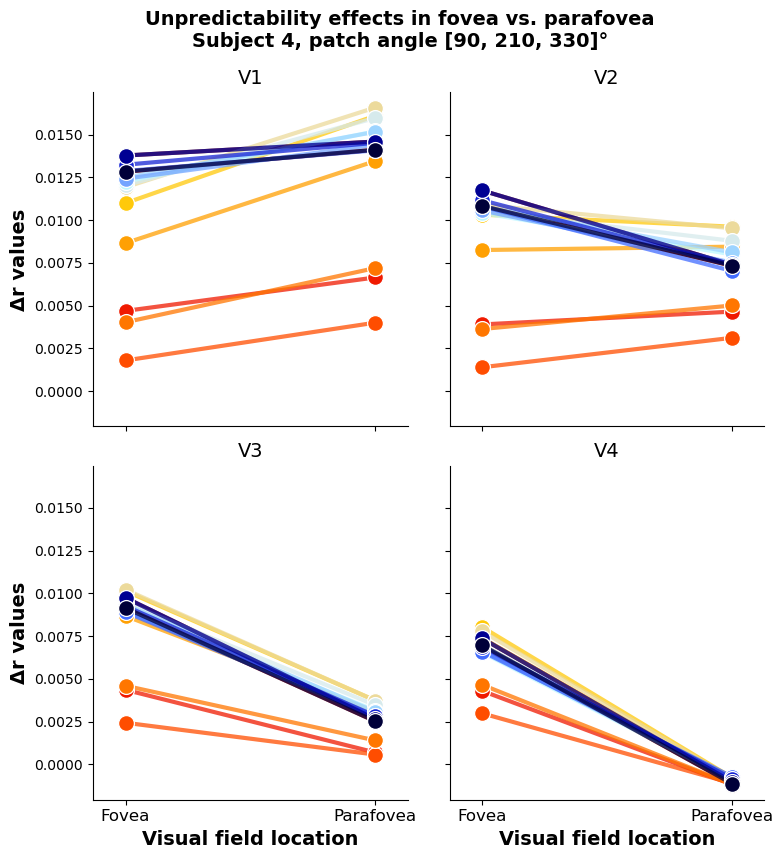

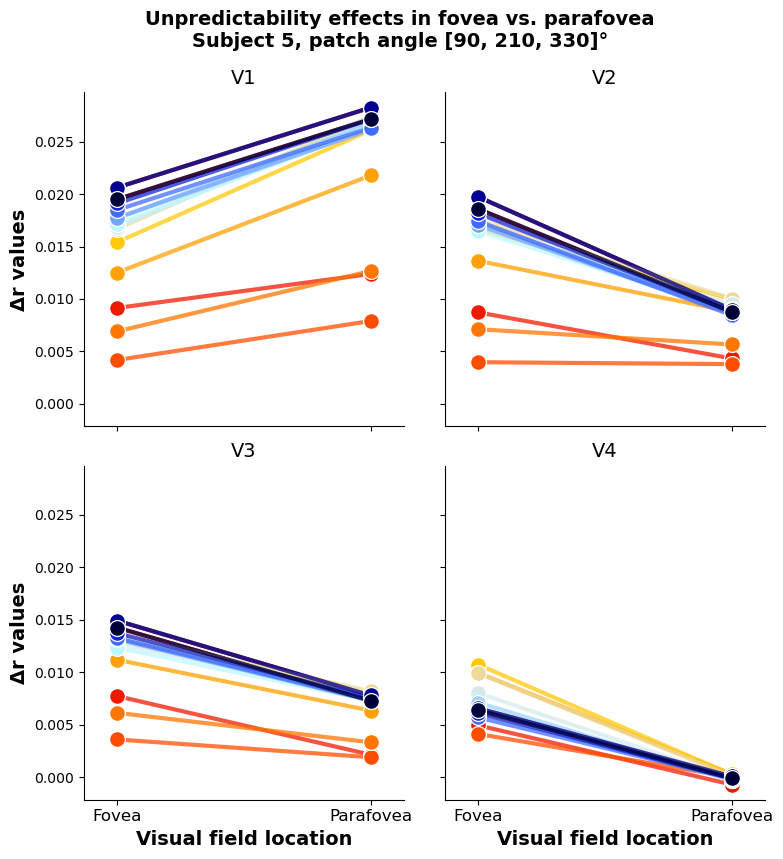

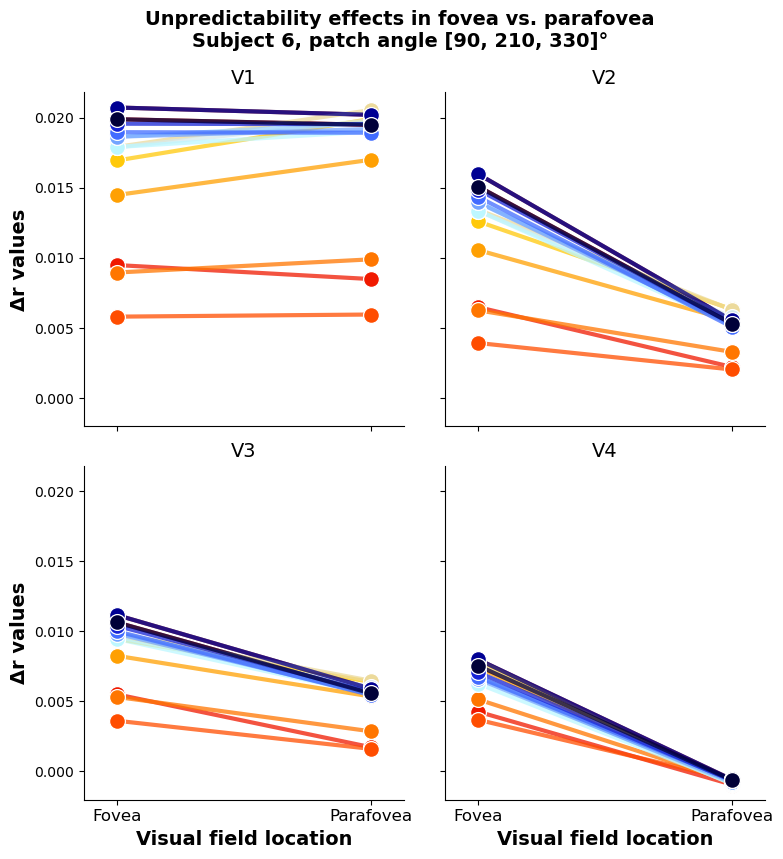

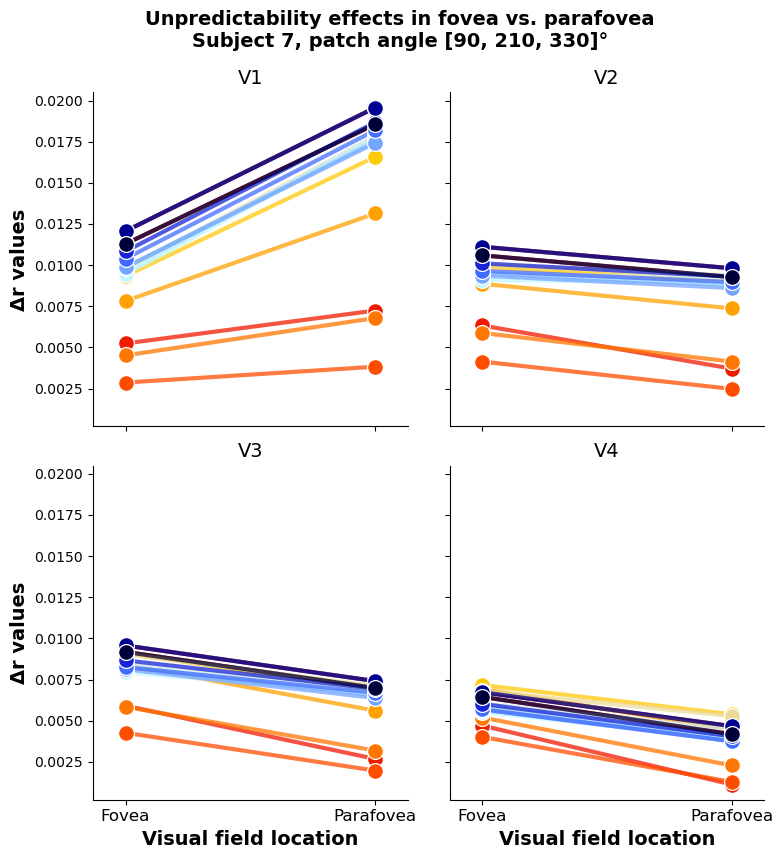

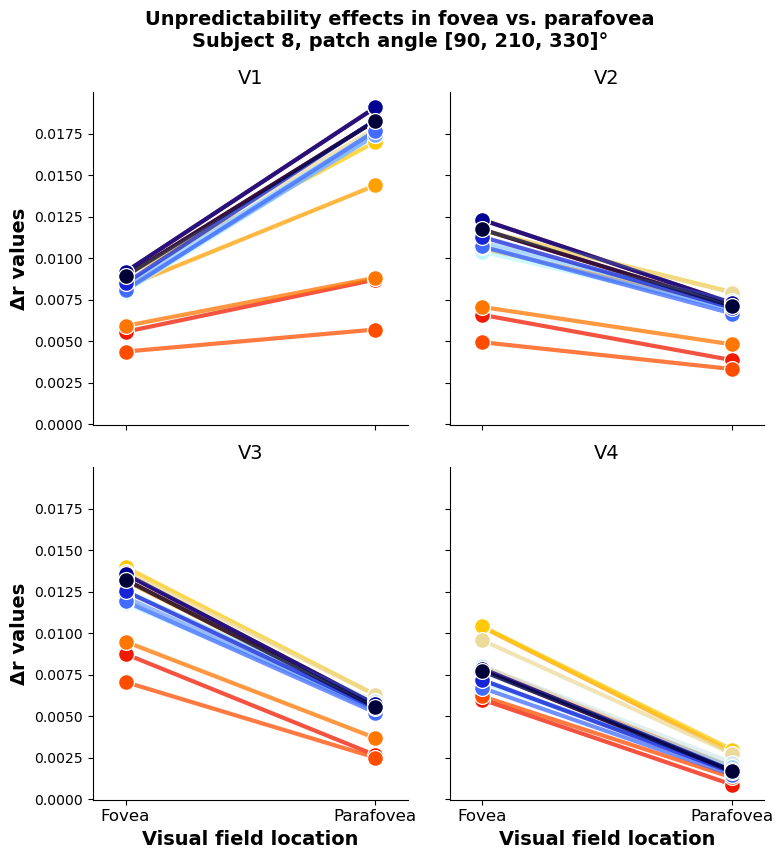

In [3]:
# fovperi_per_lay(subject="subj04", statistic="beta_unpred", angles=[90, 210, 330], alpha=1, cmap="jet")
for subject in NSP.subjects:
    # for angle in [90, 210, 330]:
    fovperi_per_lay(
        subject=subject,
        statistic="delta_r",
        angles=[90, 210, 330],
        alpha=0.75,
        cmap="layassign",
    )
    # testdf = fovperi_per_lay(subject=subject, statistic="beta_unpred", angles=[330], alpha=.75, cmap="layassign")

AttributeError: 'DataFrame' object has no attribute 'iteritems'

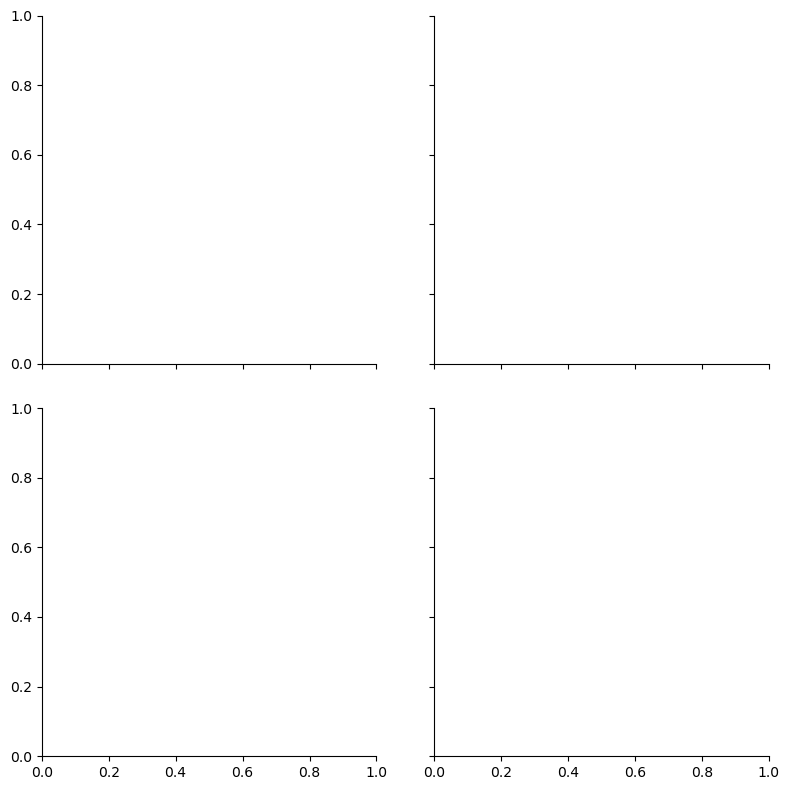

In [112]:
# fovperi_per_lay(subject="subj04", statistic="beta_unpred", angles=[90, 210, 330], alpha=1, cmap="jet")
for subject in NSP.subjects:
    # for angle in [90, 210, 330]:
    fovperi_per_lay(
        subject=subject,
        statistic="delta_r",
        angles=[90, 210, 330],
        alpha=0.75,
        cmap="layassign",
    )
    # testdf = fovperi_per_lay(subject=subject, statistic="beta_unpred", angles=[330], alpha=.75, cmap="layassign")

AttributeError: 'DataFrame' object has no attribute 'iteritems'

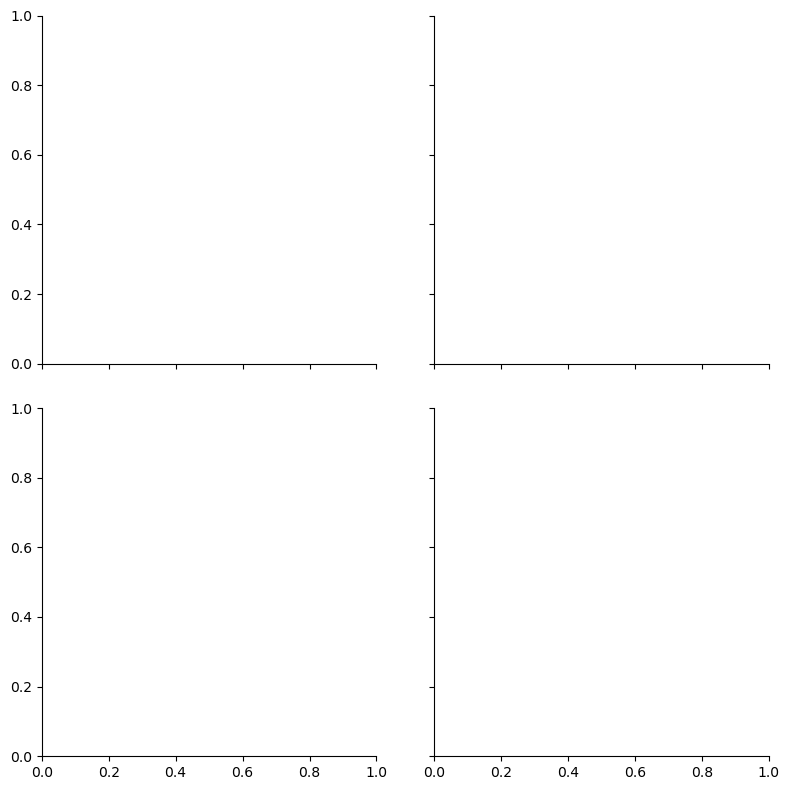

In [4]:
# fovperi_per_lay(subject="subj04", statistic="beta_unpred", angles=[90, 210, 330], alpha=1, cmap="jet")
# for subject in NSP.subjects[:1]:
fovperi_per_lay(
    subject="subj04", statistic="beta_unpred", angles=[210], alpha=0.8, cmap="layassign"
)

In [237]:
grouped

delta_r_2  delta_r_3  delta_r_4  delta_r_5  delta_r_6  delta_r_7  \
roi                                                                     
V1    0.032271   0.032022   0.031643   0.031121   0.031598   0.031894   
V2    0.050656   0.050803   0.050133   0.049419   0.049772   0.050043   
V3    0.062333   0.061816   0.061315   0.060493   0.061505   0.062040   
V4    0.037914   0.037232   0.036928   0.036187   0.037593   0.038332   

     delta_r_8  delta_r_9  delta_r_10  delta_r_11  delta_r_12  delta_r_13  \
roi                                                                         
V1    0.031177   0.031699    0.032362    0.032486    0.031642    0.027162   
V2    0.048826   0.049289    0.050037    0.049730    0.047784    0.040051   
V3    0.060519   0.061581    0.062966    0.063341    0.062125    0.054141   
V4    0.036939   0.038522    0.040512    0.041812    0.042178    0.038002   

     delta_r_14  delta_r_15  delta_r_16  delta_r_17  
roi                                                  
V1     0.023438    0.026953    0.032271    0.032022  
V2     0.034065    0.040089    0.050656    0.050803  
V3     0.047347    0.053360    0.062333    0.061816  
V4     0.033813    0.035853    0.037914    0.037232

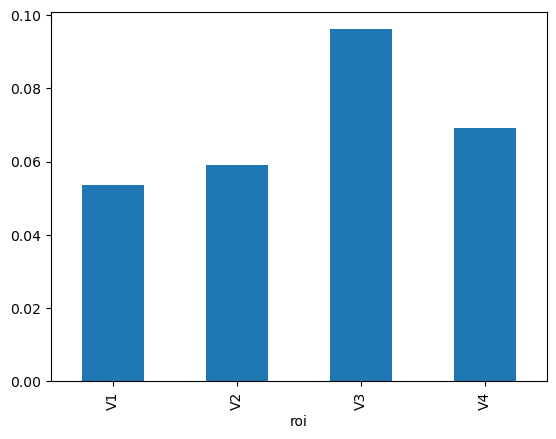

In [36]:
# Group by 'roi' and calculate the mean, excluding the first three columns
grouped = fov_df.iloc[:, 3:].groupby("roi").mean()

# Calculate the mean over all columns
fov_mean = grouped.mean(axis=1)

# Plot the mean values
fov_mean.plot(kind="bar")

# Show the plot
plt.show()

In [74]:
peri_fov_df = pd.concat([fov_mean, peri_mean], axis=1)

peri_fov_df.columns = ["Fovea", "Para-foveal"]
peri_fov_df

Fovea  Para-foveal
roi                       
V1   0.053601     0.030791
V2   0.059145     0.021063
V3   0.096151     0.033496
V4   0.069210     0.015358

In [ ]:
for subject in NSP.subjects:
    fovperi_plot(subject, "delta_r")
    # print(subject)

### I also want to check what the layer-specific impact is between fovea and para-fovea. This could inform me about the role of the type of unpredictability that perhaps can explain why V1 appears to be more responsive to unpredictability of para-foveal input.

In [72]:
# Peripheral results, delta r unpredictability
for angle_no, angle in enumerate([90]):

    peri_folder = f"unpred/vggfull/peri_ecc2.0_angle{angle}_gabor_optim"

    results = rd(
        subject=subject,
        folder=peri_folder,
        model="vggfull",
        statistic="delta_r",
        verbose=False,
        skip_norm_lay=True,
    )
    if angle_no == 0:
        peri_df = results.df
    else:
        peri_df = pd.concat([peri_df, results.df])


peri_grouped = peri_df.iloc[:, 3:].groupby("roi").mean()

peri_grouped


delta_r_2  delta_r_3  delta_r_4  delta_r_5  delta_r_6  delta_r_7  \
roi                                                                     
V1    0.015998   0.015987   0.015439   0.015114   0.015321   0.015234   
V2    0.016067   0.015953   0.015415   0.015046   0.015306   0.015080   
V3    0.000977   0.000892   0.000906   0.000897   0.001046   0.000997   
V4    0.005104   0.004970   0.004610   0.004460   0.004809   0.004725   

     delta_r_8  delta_r_9  delta_r_10  delta_r_11  delta_r_12  delta_r_13  \
roi                                                                         
V1    0.014474   0.014632    0.014777    0.014314    0.013049    0.009617   
V2    0.013981   0.013910    0.013952    0.013461    0.012474    0.009604   
V3    0.000755   0.000835    0.000941    0.000996    0.001028    0.000987   
V4    0.004018   0.004296    0.004759    0.004920    0.004897    0.004100   

     delta_r_14  delta_r_15  delta_r_16  delta_r_17  
roi                                                  
V1     0.007211    0.009880    0.015998    0.015987  
V2     0.007443    0.011126    0.016067    0.015953  
V3     0.000856    0.000761    0.000977    0.000892  
V4     0.003341    0.003989    0.005104    0.004970

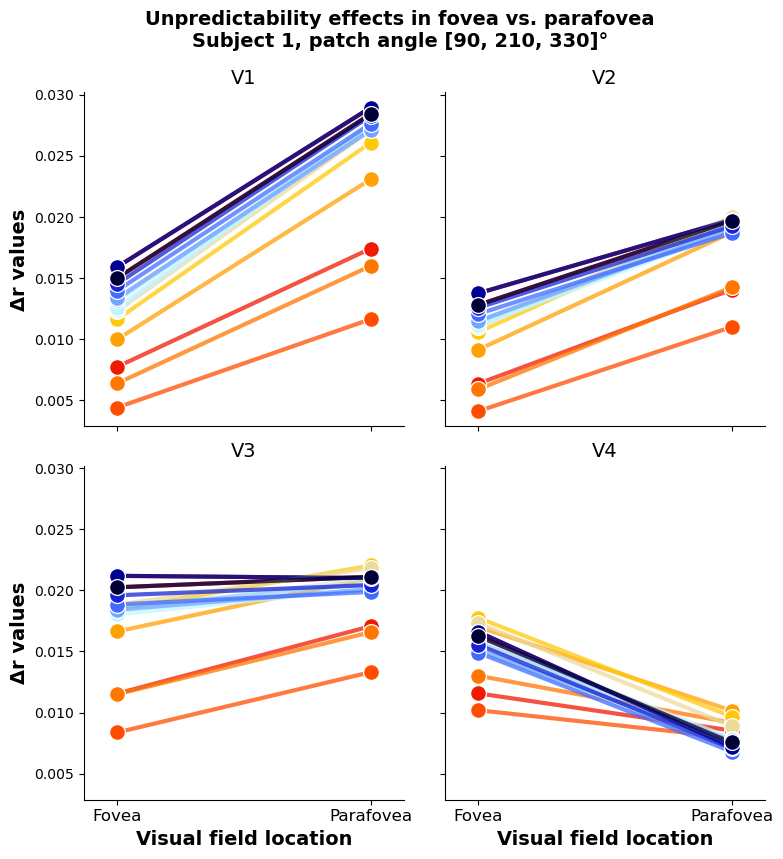

In [5]:
for subject in NSP.subjects[:1]:
    soep = fovperi_per_lay(
        subject=subject,
        statistic="delta_r",
        angles=[90, 210, 330],
        alpha=0.75,
        cmap="layassign",
    )

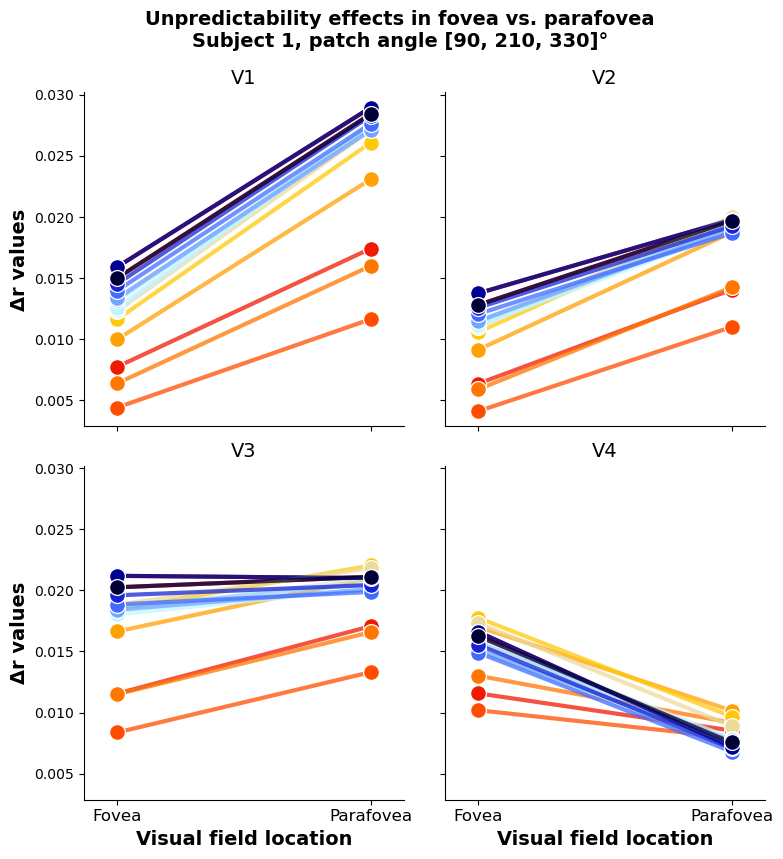

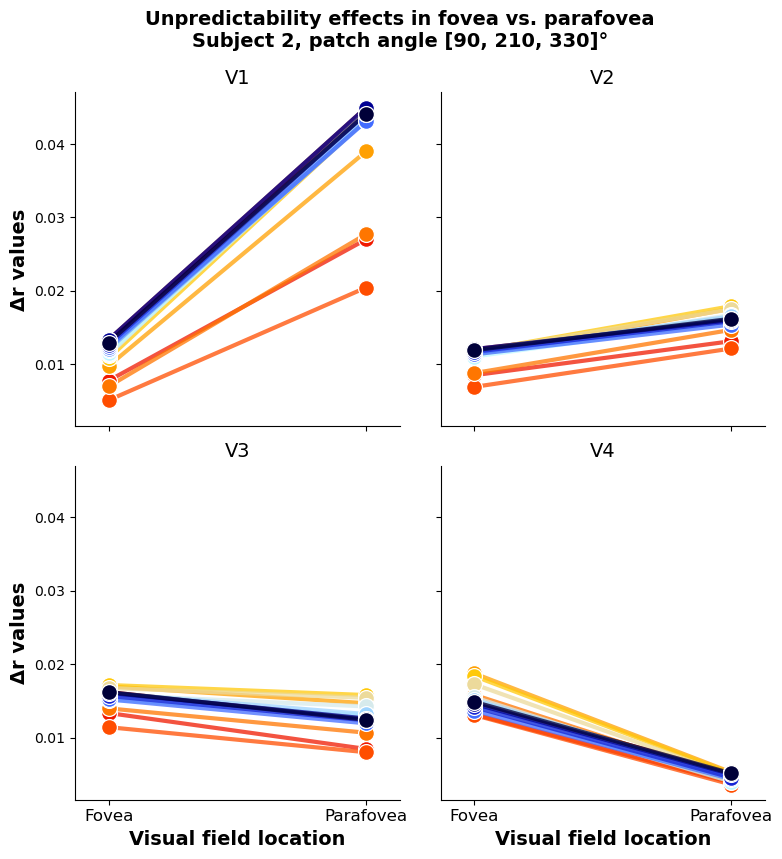

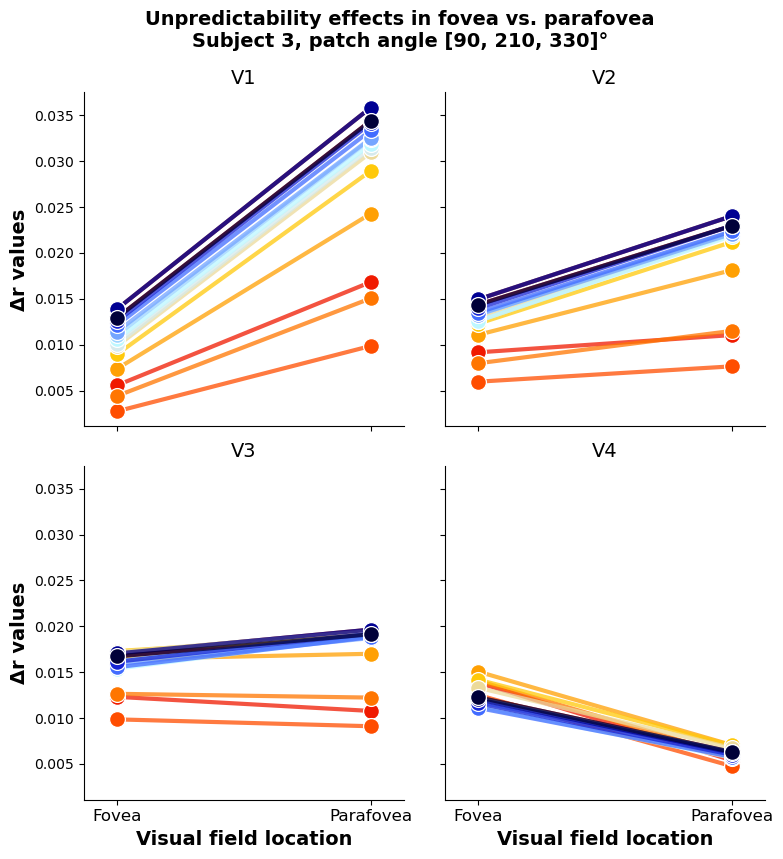

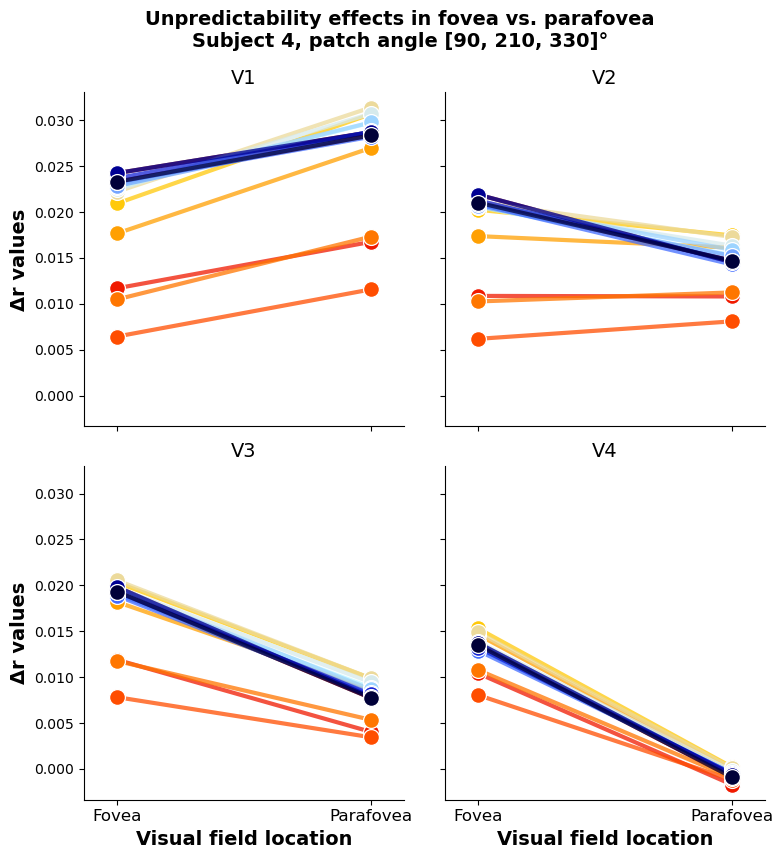

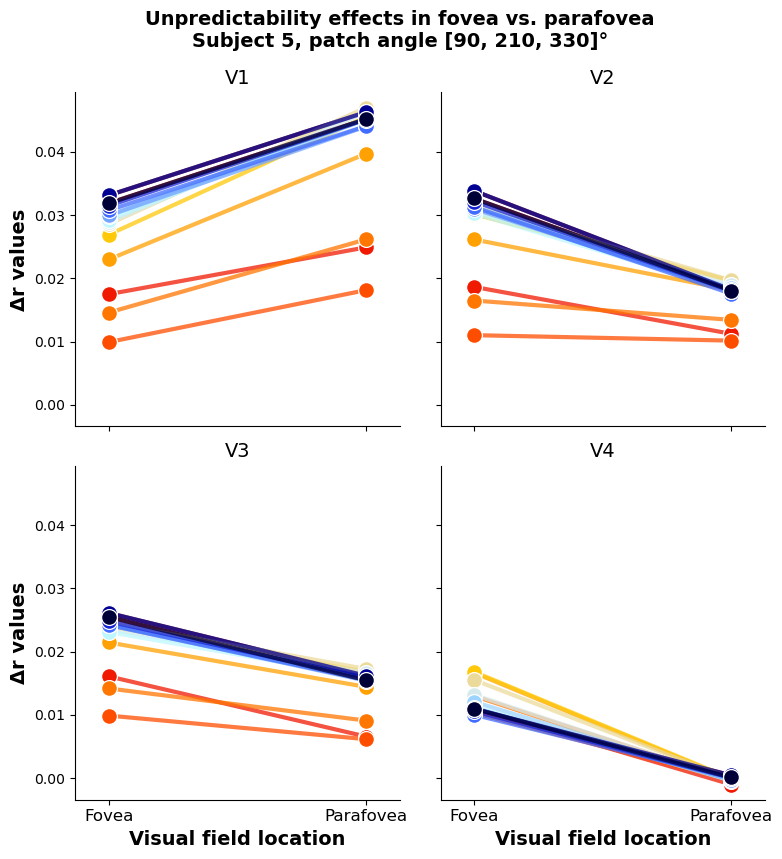

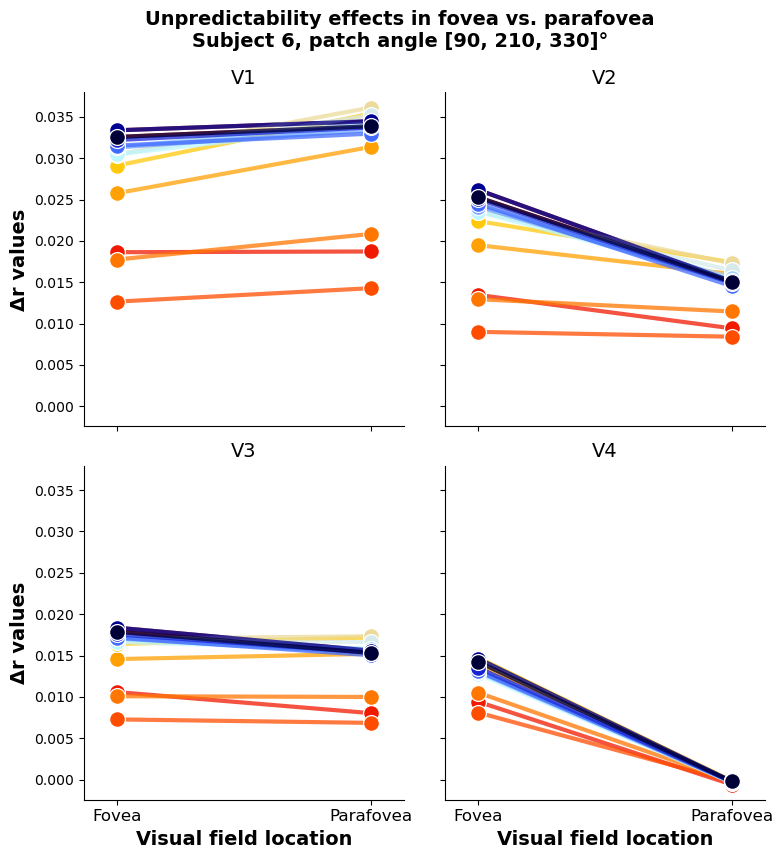

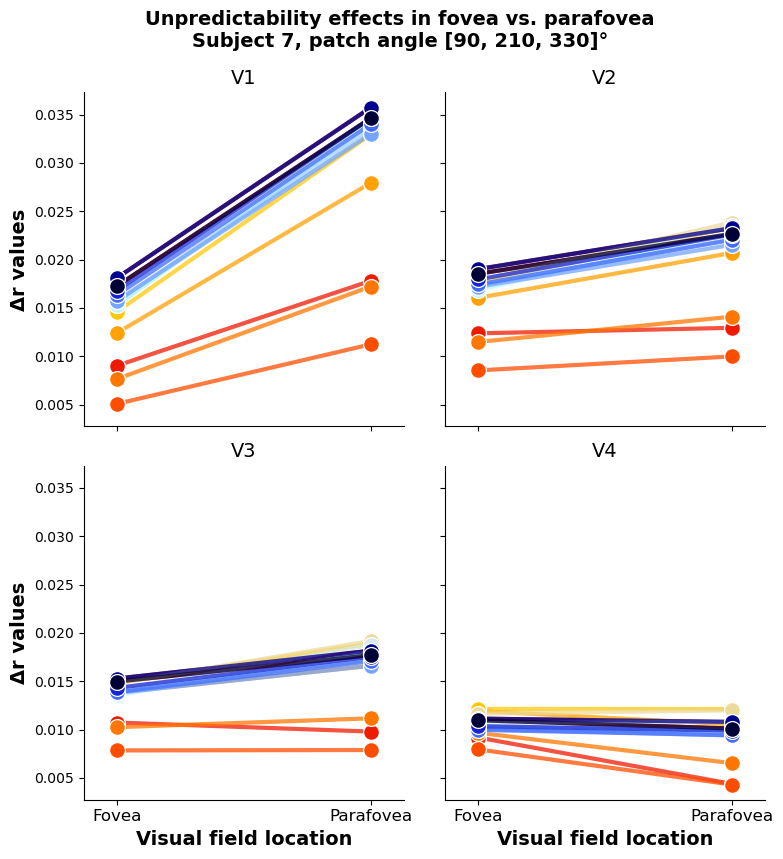

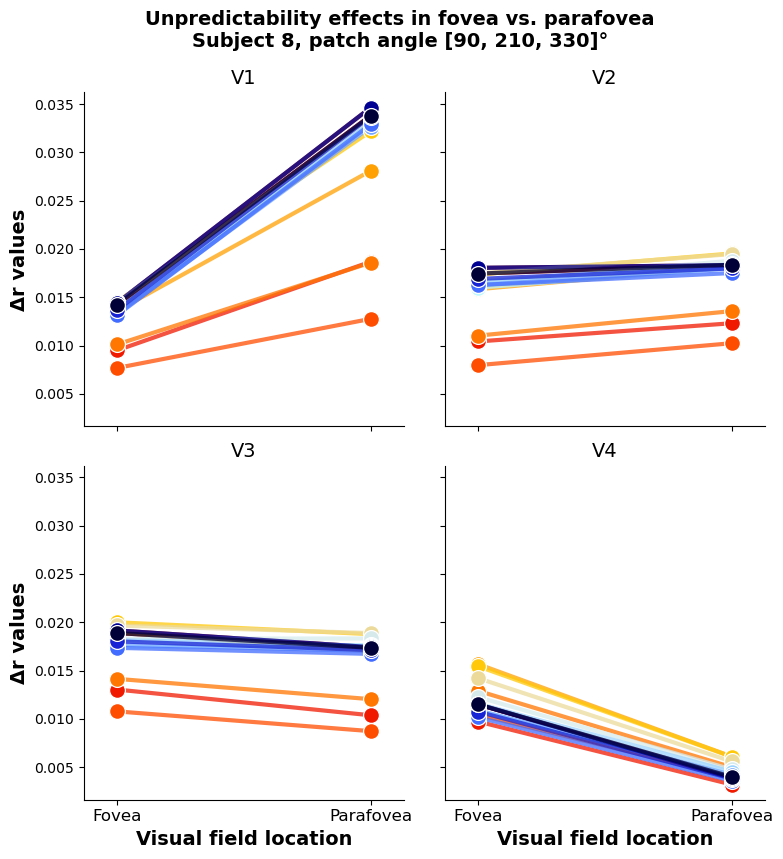

In [78]:
for subject in NSP.subjects:
    soep = fovperi_per_lay(
        subject=subject,
        statistic="delta_r",
        angles=[90, 210, 330],
        alpha=0.75,
        cmap="layassign",
    )

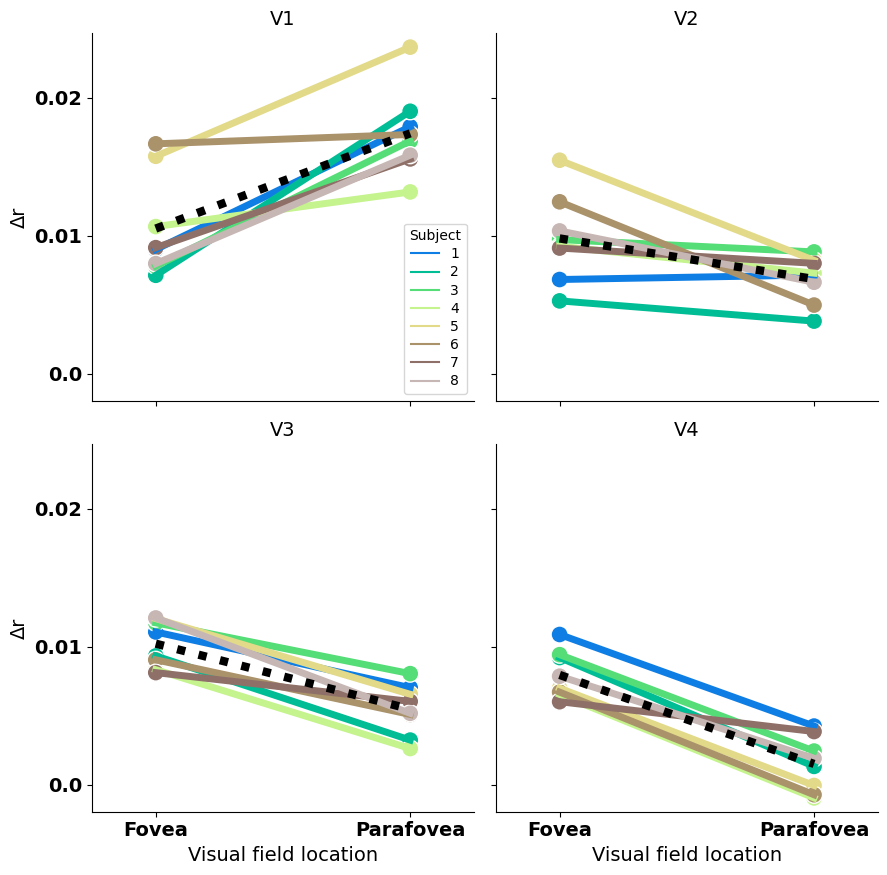

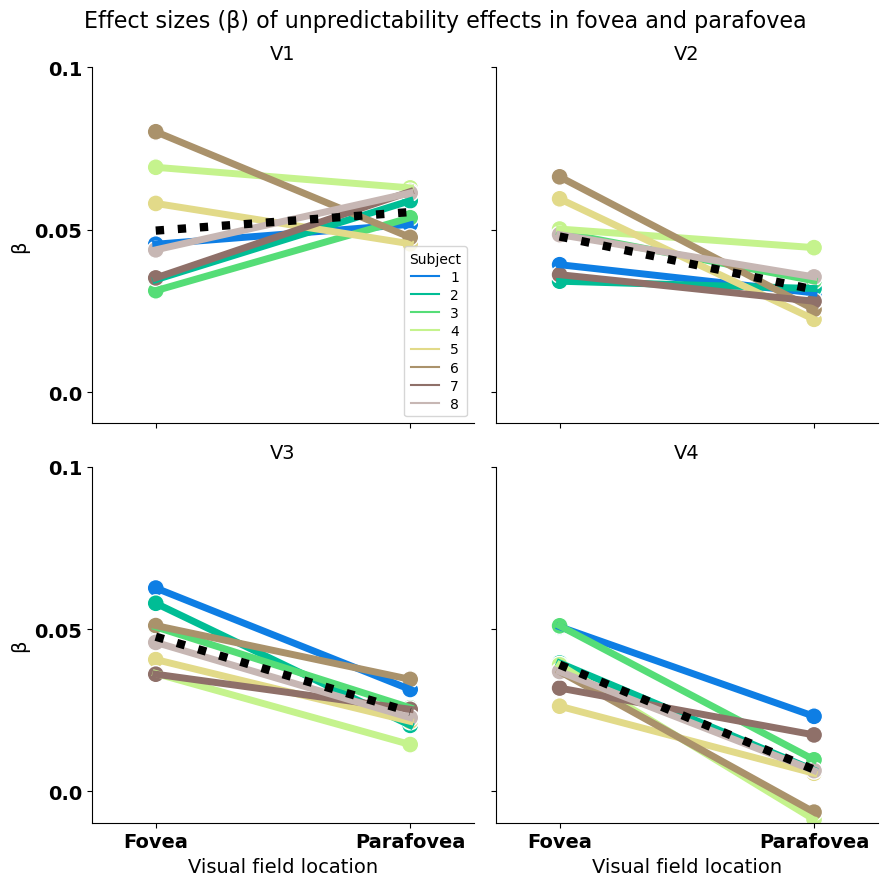

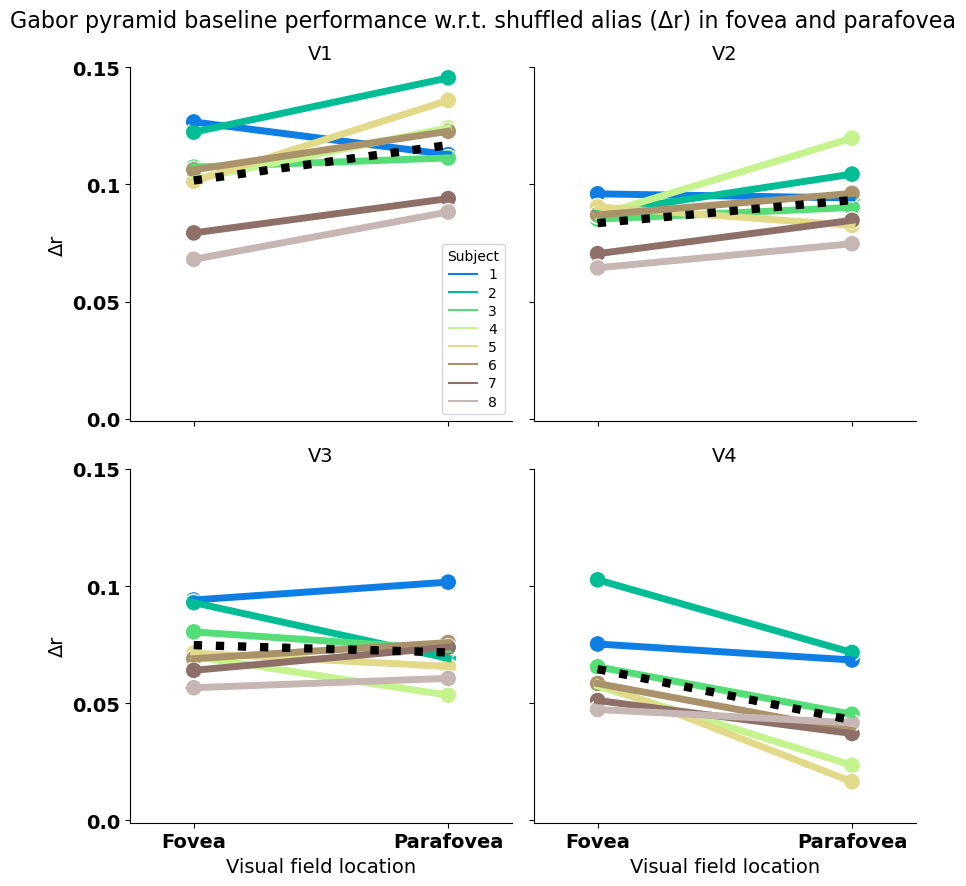

In [111]:
cmap = "terrain"
alpha_glob = 1
fovparafov_roiplot(
    subjects=NSP.subjects,
    statistic="delta_r",
    angles=[90, 210, 330],
    # custom_title="Explained additional variance (Δr) of unpredictability effects in fovea and parafovea",
    custom_title="",
    ylabel="Δr",
    cmap=cmap,
    alpha=alpha_glob,
    figsize=(9,9),
    manual_yrange=(0, 0.03, .01)
    # manual_yrange=None
)

fovparafov_roiplot(
    subjects=NSP.subjects,
    statistic="beta_unpred",
    angles=[90, 210, 330],
    custom_title="Effect sizes (β) of unpredictability effects in fovea and parafovea",
    ylabel="β",
    cmap=cmap,
    alpha=alpha_glob,
    figsize=(9,9),
    manual_yrange=(0, 0.15, .05)
    # manual_yrange=None
)
fovparafov_roiplot(
    subjects=NSP.subjects,
    statistic="delta_r_baseline",
    angles=[90, 210, 330],
    custom_title="Gabor pyramid baseline performance w.r.t. shuffled alias (Δr) in fovea and parafovea",
    ylabel="Δr",
    cmap=cmap,
    alpha=alpha_glob,
    figsize=(9,9),
    manual_yrange=(0, 0.2, .05)
    # manual_yrange=None
)

In [26]:
from funcs.utility import generate_bell_vector
# Function to plot the hypotheses for the feature and unpredictability sensitivity
def hypotheses_plot(n_layers:int=5, bell_width:float=.0115, bell_loc:float=3.0, bell_kurtosis:float=.01):

    hypothesis_1 = hypothesis_2 = np.zeros((4, n_layers))
    for i in range(4):
        loc = i/bell_loc
        # generate_bell_vector(5, 0.15, loc)
        hypothesis_1[i, :] = np.array(generate_bell_vector(n_layers, bell_width, loc, bell_kurtosis, plot = 'n'))
        
    hypothesis_3 = np.zeros((4, n_layers))
    for i in range(4):
        loc = i/bell_loc
        # generate_bell_vector(5, 0.15, loc)
        hypothesis_3[np.abs(i - 3), :] = np.array(generate_bell_vector(n_layers, bell_width, loc, bell_kurtosis, plot = 'n'))
        
    # Keeping the same values for Hypothesis 4
    hypothesis_4 = np.zeros((4, n_layers))
    for i in range(4):
        hypothesis_4[i, :] = hypothesis_1[3]

    hypotheses = [hypothesis_1, hypothesis_2, hypothesis_3, hypothesis_4]

    # Visual areas
    visual_areas = ['V1', 'V2', 'V3', 'V4']

    # Define a gradient colormap from dark blue to light red
    # cmap = LinearSegmentedColormap.from_list('NavyBlueVeryLightGreyDarkRed', ['#000080', '#CCCCCC', '#FFA500', '#FF0000'], N=n_layers)
    # cmap = LinearSegmentedColormap.from_list('NavyBlueVeryLightGreyDarkRed', ['#000039', '#000080', '#CCCCCC', '#FFA000', '#FF0025', '#800000'], N=13)
    # cmap = LinearSegmentedColormap.from_list('NavyBlueVeryLightGreyDarkRed', ['#000039', '#000090', '#6699CC', '#90DEFF','#CBEAE8', '#E9E9E9', '#F5DEB3', '#FFD700', '#FFA500', '#FF4500', '#800000'], N=13)
    cmap = LinearSegmentedColormap.from_list(
        "NavyBlueVeryLightGreyDarkRed",
        [
            "#000039",
            "#0000C0",
            "#426CFF",
            "#8DC2FF",
            "#BDF7FF",
            "#E3E3E3",
            "#FFC90A",
            "#FF8B00",
            "#FF4D00",
            "#E90000",
            "#800000",
        ],
        N=n_layers,
    )

    # Plotting
    # fig, axs = plt.subplots(1, 4, figsize=(np.array([14, 4.25])*1.1), sharey=True)
    fig, axs = plt.subplots(1, 4, figsize=(np.array([14.5, 4])*1.1), sharey=True)
        
    plt.subplots_adjust(wspace=-1)  # Adjust this value to your liking

    for i, hypothesis in enumerate(hypotheses):
        ax = axs[i]
        # Transpose the hypothesis so that each vector becomes a column
        hypothesis_t = np.transpose(hypothesis)
        bottom = np.zeros(len(hypothesis_t[0]))
        for j, data in enumerate(hypothesis_t):
            ax.bar(range(len(data)), data, bottom=bottom, edgecolor='none', linewidth=0.5, label=f'{j+1}', color=cmap(j))
            bottom += data
        ax.set_title(['Visual feature sensitivity\n\n\n', 
                    'Hypothesis 1: \nTraditionally hierarchical\nunpredictability sensitivity\n', 
                    'Hypothesis 2: \nReversed hierarchical\nunpredictability sensitivity\n', 
                    'Hypothesis 3: \nNon-hierarchical\nunpredictability sensitivity\n'][i], 
                    fontweight='normal', family = 'sans-serif', fontsize = 16)
        ax.set_ylim(0, 1)  # Adjust the y-axis limits based on your data range
        ax.set_yticks([0, 0.5, 1])  # Set y-ticks
        ax.set_yticklabels([0, 50, 100], fontweight="bold", fontsize=14)  # Change y-tick labels
        ax.spines['top'].set_visible(False)  # Remove top border
        ax.spines['right'].set_visible(False)  # Remove right border
        ax.set_xticks(range(len(visual_areas)))  # Set x-ticks
        ax.set_xticklabels(visual_areas, fontweight="bold", fontsize=14)  # Set x-tick labels
        ax.grid(False)  # Remove grid

    # Remove 'Category' label from the bottom
    fig.text(0.5, 0, '', ha='center', va='center', fontsize=14)
    # fig.text(0.0, 0.43, 'Layer Assignment (%)', va='center', rotation='vertical', fontweight='normal', fontsize = 15)
    # fig.text(0.105, -.01, 'Visual Areas', ha='left', fontweight='normal', fontsize = 15)

    # axs[0].legend(title='CNN Layer', loc = 'upper center', bbox_to_anchor=(0.5, 1.27),
    #         ncol=n_layers, fancybox=False, shadow=False, fontsize = 11.5, columnspacing = .55)

    plt.tight_layout()
    plt.show()
    

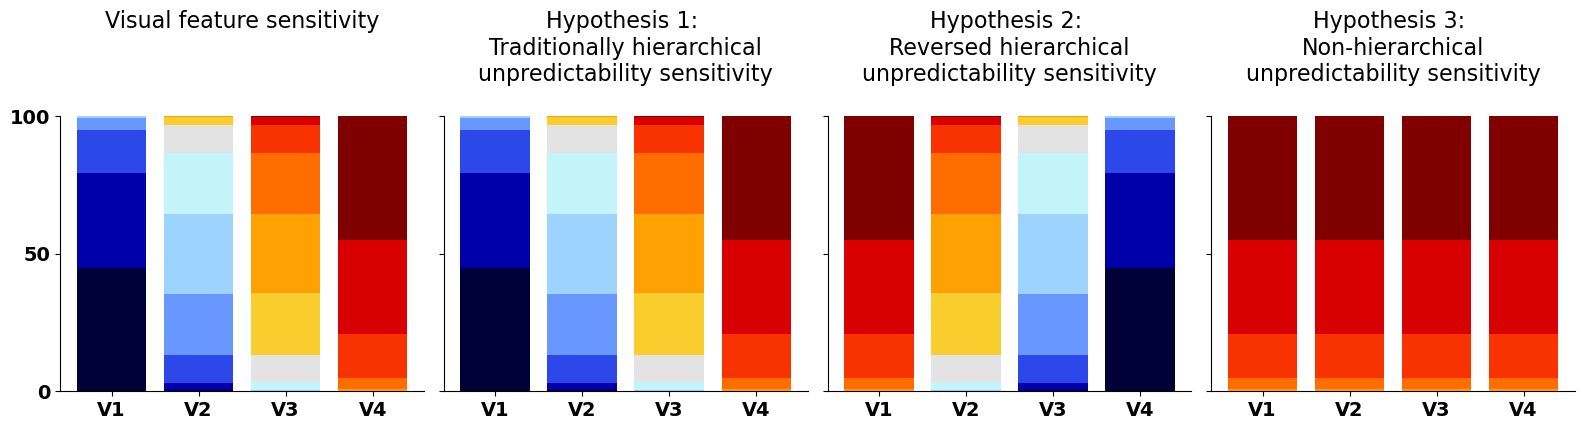

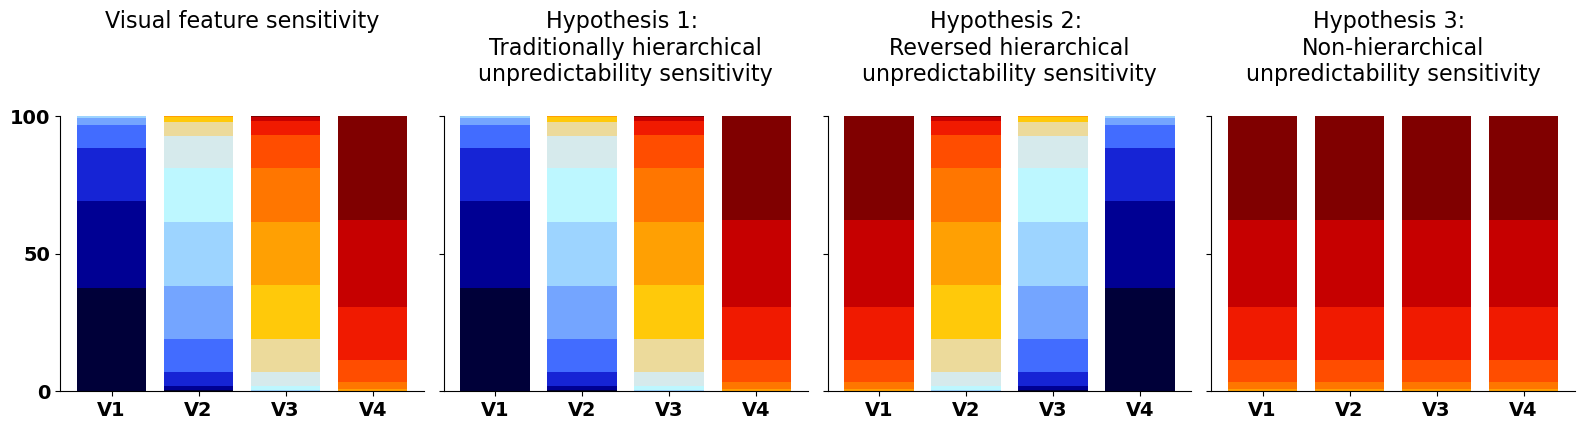

In [29]:
hypotheses_plot(n_layers=13, bell_width=.0115, bell_loc=3.0, bell_kurtosis=.01)
hypotheses_plot(n_layers=16, bell_width=.0115, bell_loc=3.0, bell_kurtosis=.01)

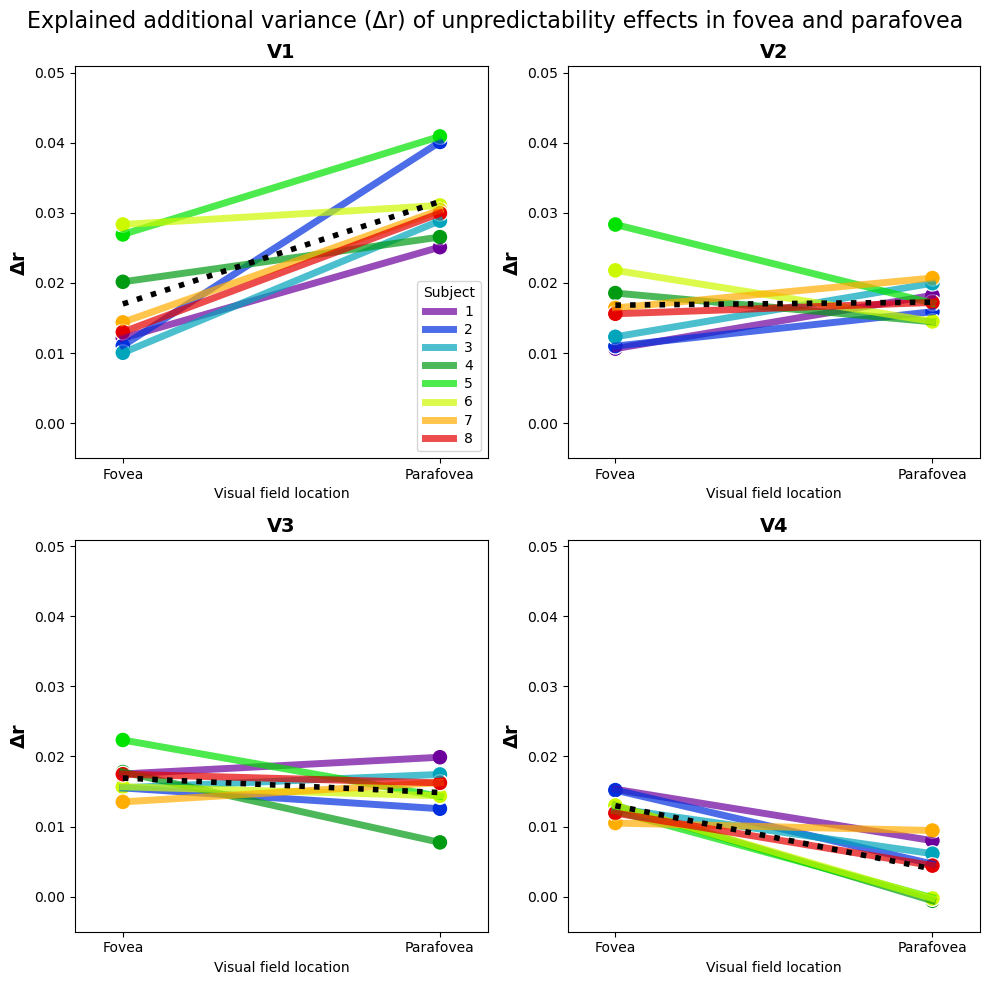

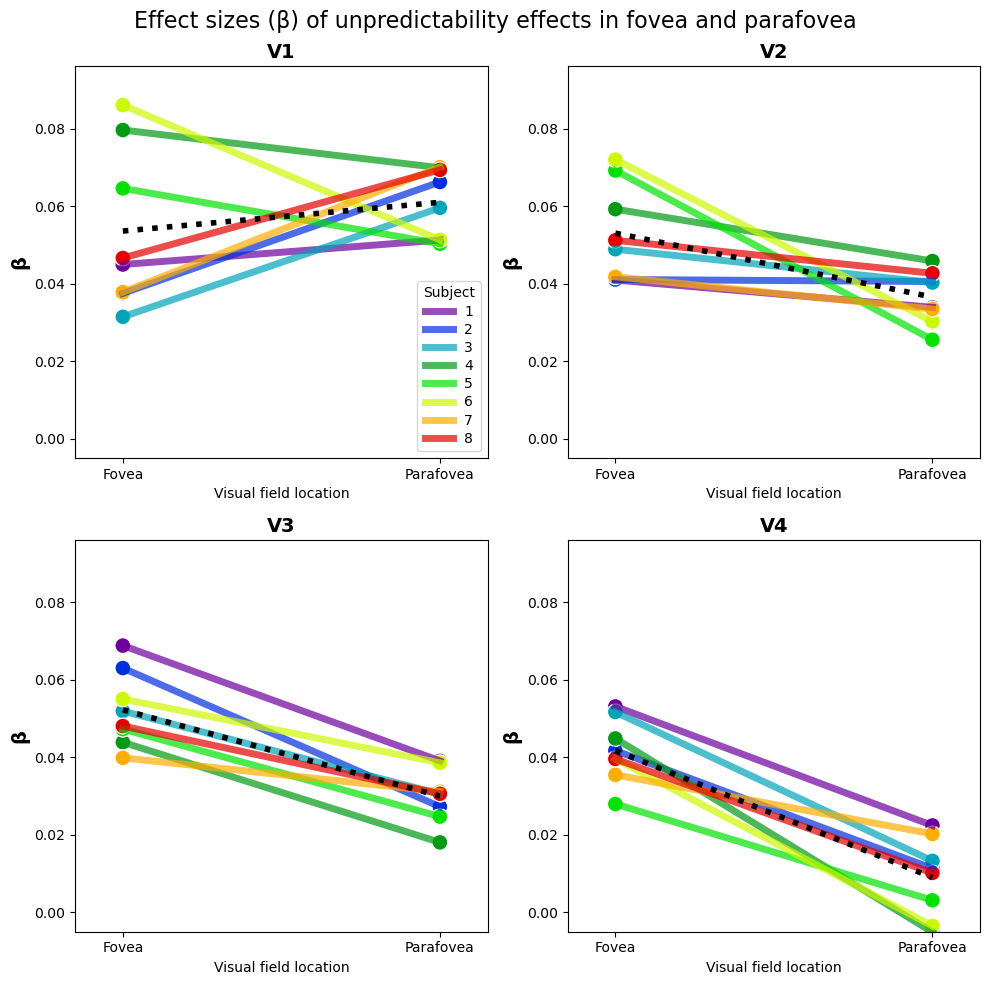

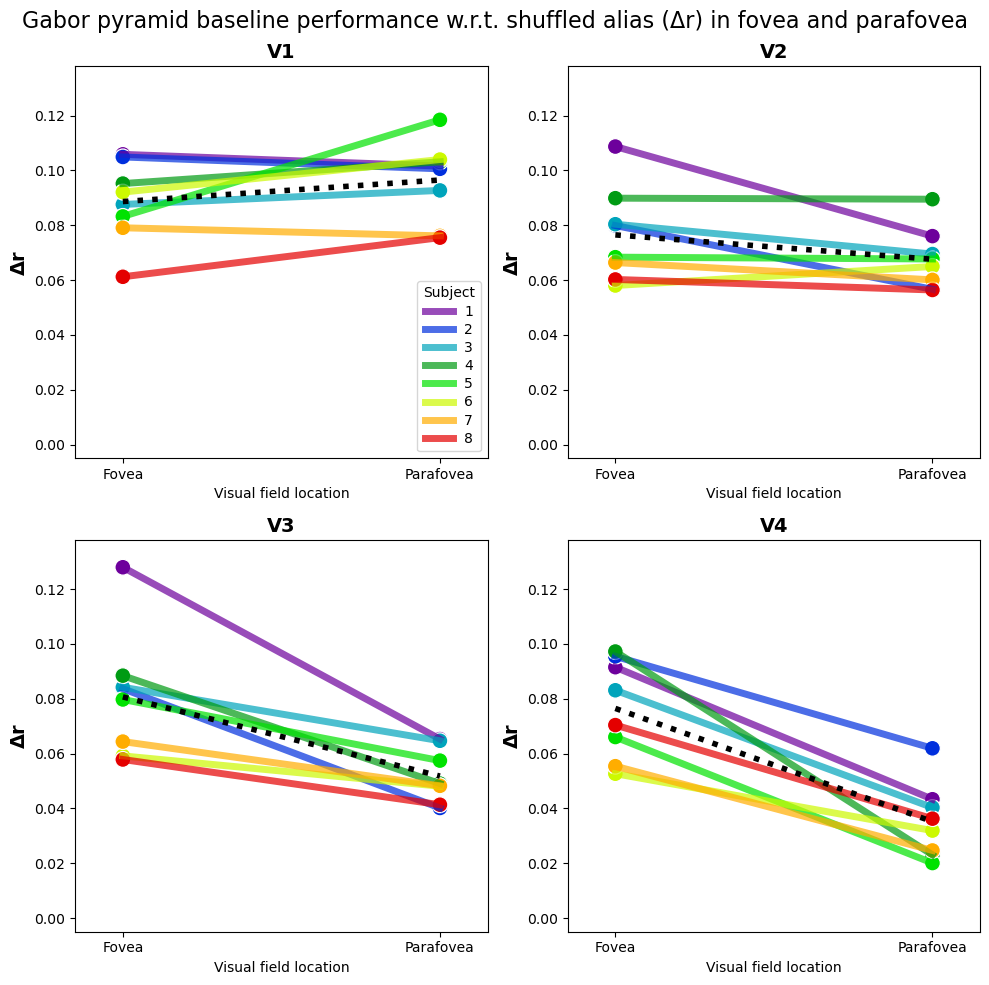

In [9]:
fovparafov_roiplot(
    subjects=NSP.subjects,
    statistic="delta_r",
    angles=[90, 210, 330],
    custom_title="Explained additional variance (Δr) of unpredictability effects in fovea and parafovea",
    ylabel="Δr",
    cmap="nipy_spectral",
    alpha=0.7,
)
fovparafov_roiplot(
    subjects=NSP.subjects,
    statistic="beta_unpred",
    angles=[90, 210, 330],
    custom_title="Effect sizes (β) of unpredictability effects in fovea and parafovea",
    ylabel="β",
    cmap="nipy_spectral",
    alpha=0.7,
)
fovparafov_roiplot(
    subjects=NSP.subjects,
    statistic="delta_r_baseline",
    angles=[90, 210, 330],
    custom_title="Gabor pyramid baseline performance w.r.t. shuffled alias (Δr) in fovea and parafovea",
    ylabel="Δr",
    cmap="nipy_spectral",
    alpha=0.7,
)

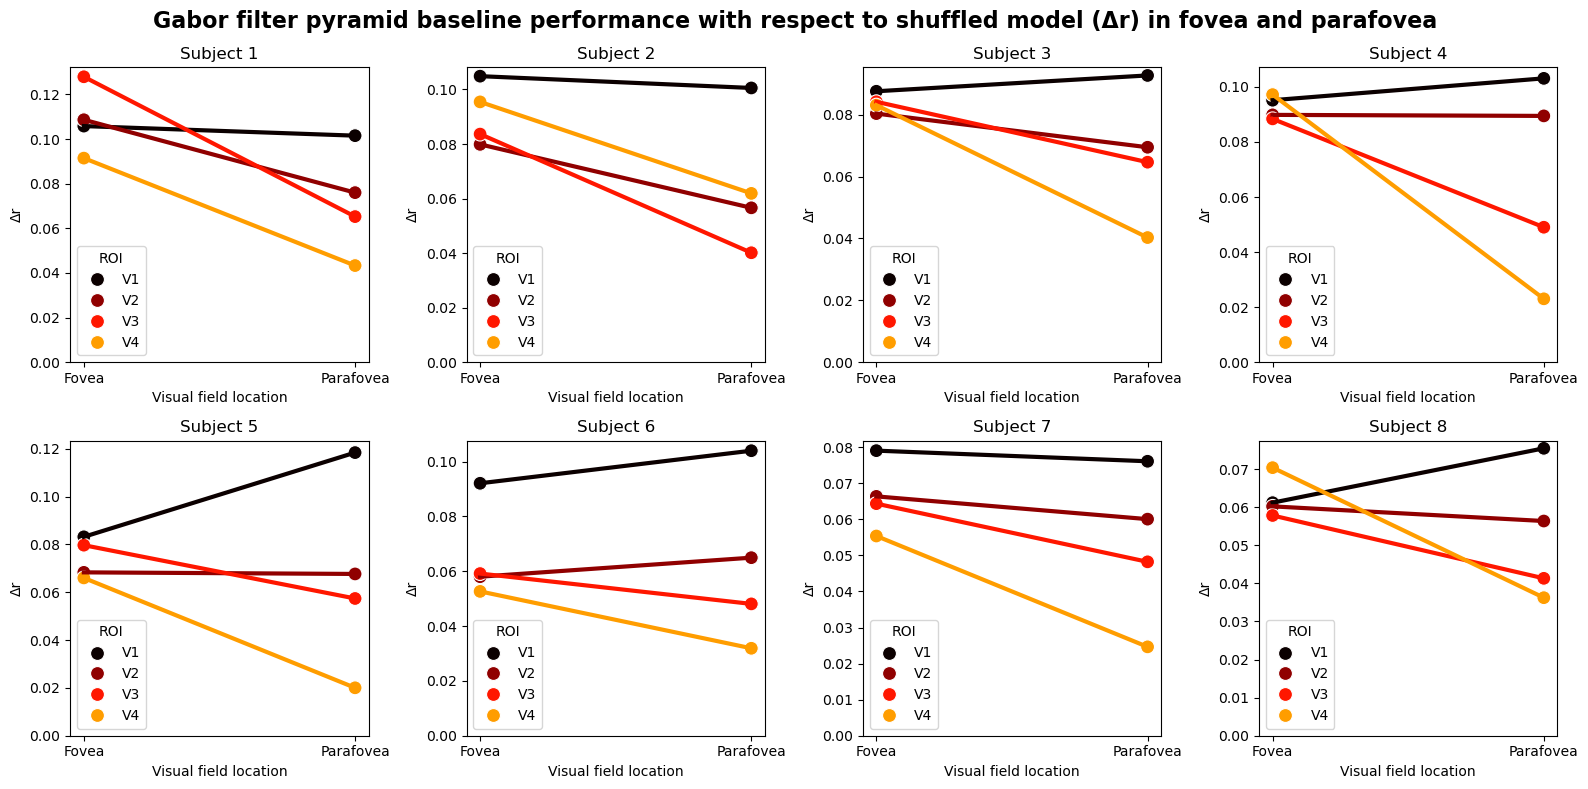

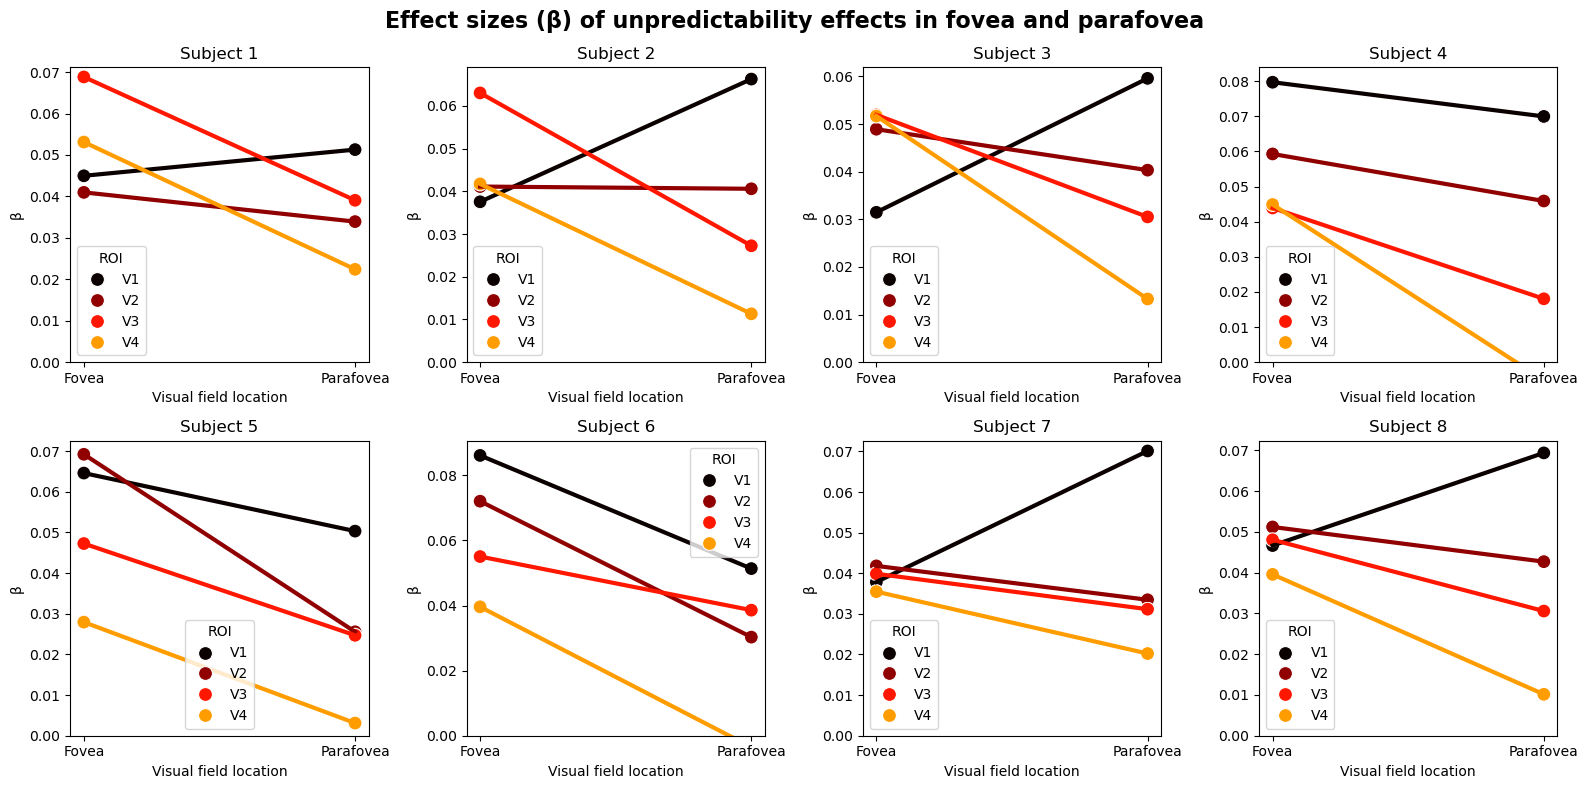

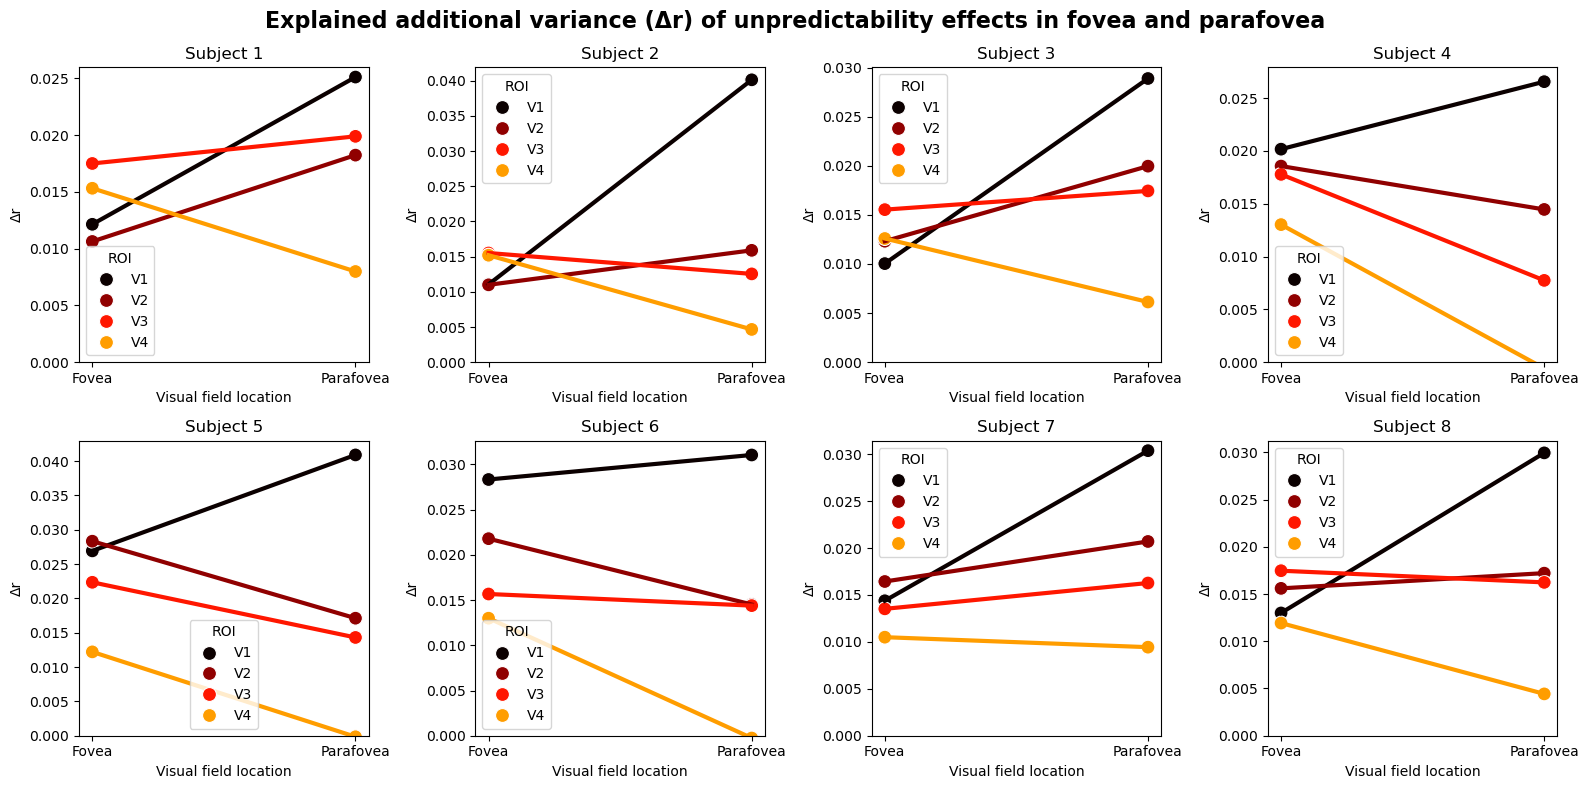

In [7]:
# for angle in [90, 210, 330]:
# fovperi_plot(NSP.subjects, "beta_unpred", angles=[angle])
# fovperi_plot("subj01", "beta_unpred", angles=[angle])

# fovperi_plot(NSP.subjects, "R_alt_model", angles=[90, 210, 330], ylabel="Δr")
fovperi_plot(
    NSP.subjects,
    "delta_r_baseline",
    angles=[90, 210, 330],
    ylabel="Δr",
    custom_title="Gabor filter pyramid baseline performance with respect to shuffled model (Δr) in fovea and parafovea",
    aggregate_layers=True,
)
fovperi_plot(
    NSP.subjects,
    "beta_unpred",
    angles=[90, 210, 330],
    ylabel="β",
    custom_title="Effect sizes (β) of unpredictability effects in fovea and parafovea",
)
fovperi_plot(
    NSP.subjects,
    "delta_r",
    angles=[90, 210, 330],
    ylabel="Δr",
    custom_title="Explained additional variance (Δr) of unpredictability effects in fovea and parafovea",
)

# fovperi_plot(NSP.subjects, "delta_r", angles=[90, 210, 330])
# fovperi_plot(NSP.subjects, "delta_r")